In [1]:
import pandas as pd
import numpy as np
import os
import torch
from torch.utils.data import Dataset
from skimage import io
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import random
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import random_split, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
from tqdm import tqdm
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from torchvision.transforms import v2

In [2]:
ROOT_DIR = '/kaggle/input/'
in_car_dir = 'hands-dataset-mini/images/'
hagrid_dir = 'hagrid-mini/hagrid/images/'
smoking_dir = '/kaggle/input/smoking-data/smoking_images/'

In [3]:
smoking_data = pd.read_csv('/kaggle/input/smoking-data/smoking_annotations.csv')
smoking_data['path'] = smoking_data['path'].apply(lambda path: smoking_dir + path)
smoking_data

,path,frame_width,frame_height,class,X,Y,width,height
0,/kaggle/input/smoking-data/smoking_images/003_...,474,316,Hand_cigarette,207.70,114.74,195.01,201.26
1,/kaggle/input/smoking-data/smoking_images/003_...,474,298,Hand_cigarette,164.40,150.45,101.50,147.55
2,/kaggle/input/smoking-data/smoking_images/003_...,360,433,Hand_cigarette,57.68,182.48,289.98,250.52
3,/kaggle/input/smoking-data/smoking_images/003_...,474,355,Hand_cigarette,133.49,250.18,138.76,88.44
4,/kaggle/input/smoking-data/smoking_images/003_...,474,266,Hand_cigarette,144.83,78.93,88.77,97.28
...,...,...,...,...,...,...,...,...
1977,/kaggle/input/smoking-data/smoking_images/018_...,275,183,Hand_cigarette,79.83,94.62,62.46,56.52
1978,/kaggle/input/smoking-data/smoking_images/018_...,276,183,Hand_cigarette,163.95,79.20,92.10,76.69
1979,/kaggle/input/smoking-data/smoking_images/018_...,275,183,Hand_cigarette,123.31,68.53,102.38,113.84
1980,/kaggle/input/smoking-data/smoking_images/018_...,300,168,Hand_cigarette,172.37,93.55,32.29,48.99


In [4]:
hagrid_data = pd.read_csv('/kaggle/input/hagrid-mini/hagrid/annotations.csv')
hagrid_data['path'] = hagrid_data['path'].apply(lambda path: hagrid_dir + path)
hagrid_data

,path,frame_width,frame_height,class,X,Y,width,height
0,hagrid-mini/hagrid/images/000b353f-9b45-454e-b...,1053,1276,Hand_empty,155,39,456,473
1,hagrid-mini/hagrid/images/000b9676-731b-4001-a...,788,788,Hand_empty,0,160,124,169
2,hagrid-mini/hagrid/images/000bf8d9-991d-4744-9...,634,788,Hand_empty,450,27,184,254
3,hagrid-mini/hagrid/images/000c55f3-a2c5-4dc0-9...,784,784,Hand_empty,520,165,205,269
4,hagrid-mini/hagrid/images/000de146-3f93-480d-b...,788,788,Hand_empty,528,40,260,298
...,...,...,...,...,...,...,...,...
2995,hagrid-mini/hagrid/images/2ec06634-6370-45ba-a...,777,408,Hand_empty,569,0,164,164
2996,hagrid-mini/hagrid/images/2ec0bc64-38f4-492d-8...,1368,1565,Hand_empty,207,81,267,245
2997,hagrid-mini/hagrid/images/2ecbf1d5-a85c-4751-9...,316,316,Hand_empty,271,28,45,53
2998,hagrid-mini/hagrid/images/2ecca527-c6a7-4f07-8...,863,944,Hand_empty,539,289,169,171


In [5]:
data = pd.read_csv('/kaggle/input/hands-dataset-mini/annotations.csv')
data['path'] = data['path'].apply(lambda path: in_car_dir + path)
data = data.drop(data[data['class'] == 'Hand_food'].index)
data

,path,frame_width,frame_height,class,X,Y,width,height
0,hands-dataset-mini/images/00cdf039-5154-494c-b...,640,510,Hand_unknown,115.60,367.98,245.83,111.90
1,hands-dataset-mini/images/00cdf039-5154-494c-b...,640,510,Hand_empty,292.86,104.29,130.00,179.28
2,hands-dataset-mini/images/00cdf039-5154-494c-b...,640,510,Hand_empty,315.86,88.50,125.00,155.00
3,hands-dataset-mini/images/00cdf039-5154-494c-b...,640,510,Hand_empty,319.43,82.79,123.57,165.00
4,hands-dataset-mini/images/00cdf039-5154-494c-b...,640,510,Hand_empty,321.57,87.79,125.72,157.14
...,...,...,...,...,...,...,...,...
26265,hands-dataset-mini/images/2d8a53ec-a281-43a4-b...,1080,1920,Hand_over_wheel,195.82,1728.93,349.79,191.07
26266,hands-dataset-mini/images/2d8a53ec-a281-43a4-b...,1080,1920,Hand_over_wheel,201.43,1723.32,362.89,196.68
26267,hands-dataset-mini/images/2d8a53ec-a281-43a4-b...,1080,1920,Hand_over_wheel,186.47,1710.22,375.98,209.78
26268,hands-dataset-mini/images/2d8a53ec-a281-43a4-b...,1080,1920,Hand_over_wheel,178.99,1706.48,370.37,213.52


In [6]:
data = pd.concat([data, hagrid_data, smoking_data], ignore_index=True)
data

,path,frame_width,frame_height,class,X,Y,width,height
0,hands-dataset-mini/images/00cdf039-5154-494c-b...,640,510,Hand_unknown,115.60,367.98,245.83,111.90
1,hands-dataset-mini/images/00cdf039-5154-494c-b...,640,510,Hand_empty,292.86,104.29,130.00,179.28
2,hands-dataset-mini/images/00cdf039-5154-494c-b...,640,510,Hand_empty,315.86,88.50,125.00,155.00
3,hands-dataset-mini/images/00cdf039-5154-494c-b...,640,510,Hand_empty,319.43,82.79,123.57,165.00
4,hands-dataset-mini/images/00cdf039-5154-494c-b...,640,510,Hand_empty,321.57,87.79,125.72,157.14
...,...,...,...,...,...,...,...,...
31223,/kaggle/input/smoking-data/smoking_images/018_...,275,183,Hand_cigarette,79.83,94.62,62.46,56.52
31224,/kaggle/input/smoking-data/smoking_images/018_...,276,183,Hand_cigarette,163.95,79.20,92.10,76.69
31225,/kaggle/input/smoking-data/smoking_images/018_...,275,183,Hand_cigarette,123.31,68.53,102.38,113.84
31226,/kaggle/input/smoking-data/smoking_images/018_...,300,168,Hand_cigarette,172.37,93.55,32.29,48.99


In [7]:
empty_images_paths = []
images = os.listdir('/kaggle/input/hands-dataset-mini/images')
for image_path in images:
    if in_car_dir + image_path not in data['path'].values:
        empty_images_paths.append(in_car_dir + image_path)

In [8]:
no_hands_data = pd.DataFrame([{'path': path,
                               'frame_width': None,
                               'frame_height': None,
                               'class': 'Not_hand',
                               'X': None,
                               'Y': None,
                               'width': None,
                               'height': None} for path in empty_images_paths])

In [9]:
no_hands_data

,path,frame_width,frame_height,class,X,Y,width,height
0,hands-dataset-mini/images/2d8a53ec-a281-43a4-b...,None,None,Not_hand,None,None,None,None
1,hands-dataset-mini/images/2d8a53ec-a281-43a4-b...,None,None,Not_hand,None,None,None,None
2,hands-dataset-mini/images/2d8a53ec-a281-43a4-b...,None,None,Not_hand,None,None,None,None
3,hands-dataset-mini/images/1fde2218-dba6-4aa1-b...,None,None,Not_hand,None,None,None,None
4,hands-dataset-mini/images/1e3e3b0d-721f-46b4-9...,None,None,Not_hand,None,None,None,None
...,...,...,...,...,...,...,...,...
25562,hands-dataset-mini/images/1d0e109f-1aa0-45bd-8...,None,None,Not_hand,None,None,None,None
25563,hands-dataset-mini/images/1a6354fd-d0d5-45a3-9...,None,None,Not_hand,None,None,None,None
25564,hands-dataset-mini/images/1e3e3b0d-721f-46b4-9...,None,None,Not_hand,None,None,None,None
25565,hands-dataset-mini/images/1e3e3b0d-721f-46b4-9...,None,None,Not_hand,None,None,None,None


In [10]:
data = pd.concat([data, no_hands_data[:10000]], ignore_index=True)

/tmp/ipykernel_34/2201229204.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat([data, no_hands_data[:10000]], ignore_index=True)


In [11]:
data.shape

(41228, 8)

In [12]:
n_classes = len(data['class'].unique())
data['class'].unique()

array(['Hand_unknown', 'Hand_empty', 'Hand_cellular', 'Hand_over_wheel',
       'Hand_under_wheel', 'Hand_cigarette', 'Hand_vape', 'Not_hand'],
      dtype=object)

In [13]:
def plot_classes_distribution(data: pd.DataFrame):
    sns.displot(data, x='class')
    plt.xticks(rotation=30)
    plt.show()

In [14]:
torch.manual_seed(54)

## Распределение классов

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


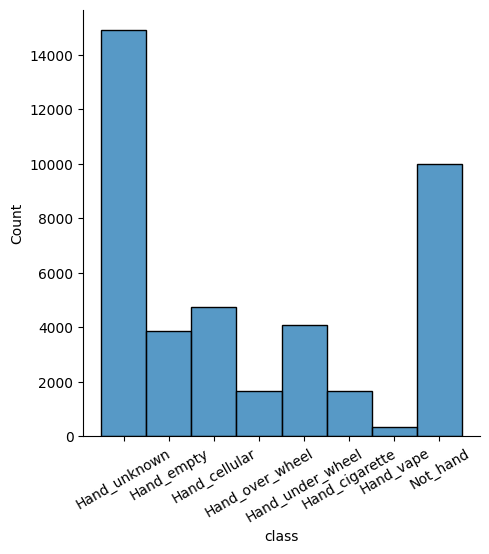

In [15]:
plot_classes_distribution(data)

## Распределение классов на картинках, где бокс не меньше 50 пикселей в длину и ширину

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


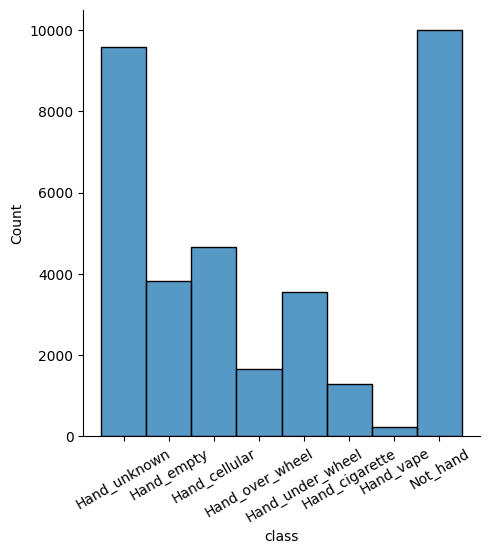

In [16]:
data = data[(data['height'] > 50) & (data['width'] > 50) | (data['class'] == 'Not_hand')]
plot_classes_distribution(data)

## Копирование данных для дальнейших онлайн-аугментаций

In [17]:
# TODO:
#1) разделить датафрейм на трейн и тест (6:4)
#2) в трейне накопировать редкие данные 
#3) создать 2 датасета: трейн и тест, трейн разделить на трейн и вал (это далее, где создание датасета)

## Кодирование классов

In [18]:
le = LabelEncoder()
data['class'] = le.fit_transform(data['class'])

In [19]:
data.head()

,path,frame_width,frame_height,class,X,Y,width,height
0,hands-dataset-mini/images/00cdf039-5154-494c-b...,640,510,5,115.60,367.98,245.83,111.90
1,hands-dataset-mini/images/00cdf039-5154-494c-b...,640,510,2,292.86,104.29,130.00,179.28
2,hands-dataset-mini/images/00cdf039-5154-494c-b...,640,510,2,315.86,88.50,125.00,155.00
3,hands-dataset-mini/images/00cdf039-5154-494c-b...,640,510,2,319.43,82.79,123.57,165.00
4,hands-dataset-mini/images/00cdf039-5154-494c-b...,640,510,2,321.57,87.79,125.72,157.14


In [20]:
data.shape

(34790, 8)

In [21]:
np.unique(data['class'].values)

array([0, 1, 2, 3, 4, 5, 6, 7])

In [22]:
le.inverse_transform(np.unique(data['class'].values))

array(['Hand_cellular', 'Hand_cigarette', 'Hand_empty', 'Hand_over_wheel',
       'Hand_under_wheel', 'Hand_unknown', 'Hand_vape', 'Not_hand'],
      dtype=object)

In [23]:
classes_dict = dict(zip(le.inverse_transform(np.unique(data['class'].values)), np.unique(data['class'].values)))
classes_dict

{'Hand_cellular': 0,
 'Hand_cigarette': 1,
 'Hand_empty': 2,
 'Hand_over_wheel': 3,
 'Hand_under_wheel': 4,
 'Hand_unknown': 5,
 'Hand_vape': 6,
 'Not_hand': 7}

In [24]:
train_data, test_data = train_test_split(data, test_size=0.35)
train_data, val_data = train_test_split(train_data, test_size=0.2)

In [25]:
classes_to_double = [classes_dict['Hand_over_wheel'], classes_dict['Hand_vape'], classes_dict['Hand_cigarette']]
aug_train_data = train_data[train_data['class'].isin(classes_to_double)]

In [26]:
len(train_data)

18090

In [27]:
len(aug_train_data)

1656

In [28]:
train_data = pd.concat([train_data, aug_train_data], ignore_index=True)
train_data

,path,frame_width,frame_height,class,X,Y,width,height
0,hands-dataset-mini/images/2d8a53ec-a281-43a4-b...,None,None,7,NaN,NaN,NaN,NaN
1,hands-dataset-mini/images/0e69bfa9-6107-45da-9...,640,510,0,336.77,406.82,150.45,73.14
2,hands-dataset-mini/images/1be5d617-fe48-44ea-b...,640,510,0,136.82,376.85,212.13,103.06
3,hands-dataset-mini/images/2d8a53ec-a281-43a4-b...,1080,1920,3,110.62,1478.75,433.97,441.25
4,hands-dataset-mini/images/1e3e3b0d-721f-46b4-9...,1080,1920,4,0.00,1751.00,543.00,168.00
...,...,...,...,...,...,...,...,...
19741,hands-dataset-mini/images/2d8a53ec-a281-43a4-b...,1080,1920,3,128.51,1693.70,422.44,226.03
19742,hands-dataset-mini/images/1a7cea27-73d9-4333-a...,640,510,3,0.00,281.22,208.19,161.57
19743,/kaggle/input/smoking-data/smoking_images/011_...,275,183,6,13.95,20.12,129.67,162.88
19744,hands-dataset-mini/images/2d8a53ec-a281-43a4-b...,1080,1920,3,212.98,1759.17,367.61,160.83


In [29]:
def get_random_crop(image):
    frame_width, frame_height = image.size
        
    crop_height = random.randint(120, 200)
    crop_width = random.randint(120, 200)

    x = random.randint(0, frame_width - crop_width)
    y = random.randint(0, frame_height - crop_height)

    crop_area = (x, y, x + crop_width, y + crop_height)
    return image.crop(crop_area)

## Создание датасета

In [30]:
class DriverHandsDataset(Dataset):
    def __init__(self, annotations: pd.DataFrame, root_dir, transform=None):
        self.annotations = annotations
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        # image = io.imread(img_path)
        image = Image.open(img_path)
        
        y_label = torch.tensor(int(self.annotations.iloc[index]['class']))
        
        if le.inverse_transform([y_label.item()])[0] == 'Not_hand':
            image = get_random_crop(image)
            
        else:
            x, y, width, height, frame_width, frame_height = (self.annotations.iloc[index]['X'], 
                                   self.annotations.iloc[index]['Y'],
                                   self.annotations.iloc[index]['width'],
                                   self.annotations.iloc[index]['height'],
                                   self.annotations.iloc[index]['frame_width'],
                                   self.annotations.iloc[index]['frame_height'])

            crop_area = (max(0, x - random.randint(10, 30)),
                         max(0, y - random.randint(10, 30)),
                         min(x + width + random.randint(10, 30), frame_width),
                         min(y + height + random.randint(10, 30), frame_height))
            image = image.crop(crop_area)
        
        if self.transform:
            image = self.transform(image)
            
        return image, y_label

In [31]:
dataset = DriverHandsDataset(data, ROOT_DIR)

In [32]:
dataset[30000]

(<PIL.Image.Image image mode=RGB size=192x140>, tensor(7))

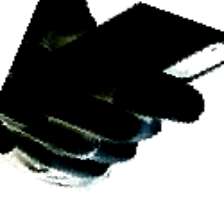

In [43]:
img = dataset[random_index][0]
# v2.ColorJitter(brightness=(0.4, 2), contrast=(1, 6),
#                saturation=(0, 2.5), hue=(-0.3,0.3))(img)
# v2.ColorJitter(hue=(-0.3,0.3))(img)
rndm_transform = transforms.Compose(
    [v2.RandomHorizontalFlip(),
     transforms.RandomRotation((-30, 30)),
     v2.ColorJitter(brightness=(0.4, 2), contrast=(1, 6),
               saturation=(0, 2.5), hue=(-0.25,0.25)),
     v2.RandomInvert(0.4),
     transforms.Resize((224, 224))]
)

rndm_transform(img)

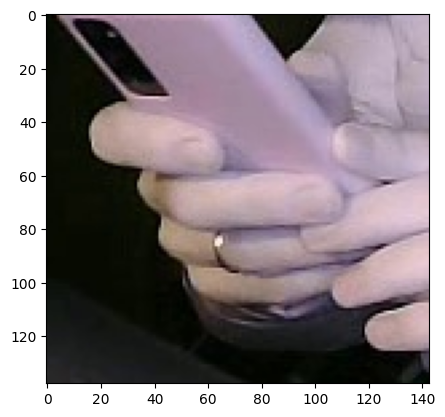

In [34]:
random_index = random.randint(0, len(dataset) - 1) 
  
# Plotting the randomly selected image 
plt.imshow(dataset[random_index][0])
plt.show()

In [46]:
basic_transform = transforms.Compose(
    [transforms.Resize((224, 224)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

In [47]:
train_transform = transforms.Compose(
    [v2.RandomHorizontalFlip(),
     transforms.RandomRotation((-30, 30)),
     v2.ColorJitter(brightness=(0.4, 2), contrast=(1, 6),
               saturation=(0, 2.5), hue=(-0.25,0.25)),
     v2.RandomInvert(0.4),
     transforms.Resize((224, 224)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

In [48]:
train_dataset = DriverHandsDataset(train_data, ROOT_DIR, transform=train_transform)
test_dataset = DriverHandsDataset(test_data, ROOT_DIR, transform=basic_transform)
val_dataset = DriverHandsDataset(val_data, ROOT_DIR, transform=basic_transform)

In [49]:
# generator = torch.Generator().manual_seed(42)
# train_dataset, test_dataset = random_split(dataset, [0.7, 0.3], generator)
# train_dataset, val_dataset = random_split(train_dataset, [0.85, 0.15], generator)

In [50]:
device = 'cuda'

In [51]:
batch_size = 32

trainloader = DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True)
testloader = DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False)
valloader = DataLoader(val_dataset, batch_size=batch_size,
                                         shuffle=False)

In [52]:
data_copy = data.copy()
class_weights = compute_class_weight(class_weight = "balanced",
                                     classes = np.unique(train_data['class'].values),
                                     y = train_data['class'].values)
class_weights = dict(zip(np.unique(data['class'].values), class_weights))

In [53]:
class_weights

{0: 1.00920245398773,
 1: 1.8414179104477613,
 2: 1.2474721941354905,
 3: 1.4003972758229284,
 4: 1.341032608695652,
 5: 0.493993993993994,
 6: 12.462121212121213,
 7: 0.4761675028946353}

# Обучение DenseNet121

In [54]:
densenet = torchvision.models.densenet121(weights=torchvision.models.DenseNet121_Weights.IMAGENET1K_V1)
densenet.classifier = nn.Linear(in_features=1024, out_features=n_classes, bias=True)

# for param in densenet.parameters():
#     param.requires_grad = False
    
# for param in densenet.classifier.parameters():
#     param.requires_grad = True
# densenet.load_state_dict(torch.load('/kaggle/working/densenet_mini_data.pt'))
# densenet.load_state_dict(torch.load('/kaggle/working/densenet_mini_data_with_hagrid.pt'))
# densenet.load_state_dict(torch.load('/kaggle/working/densenet121_full_data.pt'))
densenet = densenet.to(device)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 118MB/s] 


In [55]:
torch.Tensor(list(class_weights.values()))

tensor([ 1.0092,  1.8414,  1.2475,  1.4004,  1.3410,  0.4940, 12.4621,  0.4762])

In [56]:
criterion = nn.CrossEntropyLoss(weight=torch.Tensor(list(class_weights.values())).to(device))
optimizer = optim.SGD(densenet.parameters(), lr=0.001, momentum=0.9)

In [57]:
def validate(model):
    model.eval()
    sum_loss = 0
    for data in tqdm(valloader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        # calculate outputs by running images through the network
    #         print(images.shape)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        sum_loss += loss.item()
        
    return sum_loss /  len(valloader)

In [58]:
def train(model, criterion, optimizer, model_name, n_epochs=2):
    model.train()
    least_val_loss = None
    training_losses = []
    val_losses = []
    for epoch in range(n_epochs):  # loop over the dataset multiple times
        losses = []
        running_loss = 0.0
        for i, data in enumerate(tqdm(trainloader)):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            losses.append(loss.item())
            if i % 20 == 19:    # print every 20 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 20:.3f}')
                running_loss = 0.0
                
        training_losses.append(np.mean(losses))
        val_loss = validate(model)
        print(f'[{epoch + 1}] val loss: {val_loss}')
        
        val_losses.append(val_loss)
        
        if least_val_loss is None or val_loss < least_val_loss:
            least_val_loss = val_loss
            torch.save(model.state_dict(), f'/kaggle/working/{model_name}_best_result_augmented.pt')
            print('Saving model...')
        

    print('Finished Training')
    return training_losses, val_losses

In [60]:
dn121_train_losses, dn121_val_losses = train(densenet, criterion, optimizer, model_name='DenseNet121', n_epochs=8)

  3%|▎         | 20/617 [00:22<10:12,  1.03s/it]

[1,    20] loss: 2.043


  6%|▋         | 40/617 [00:44<10:28,  1.09s/it]

[1,    40] loss: 1.689


 10%|▉         | 60/617 [01:06<10:07,  1.09s/it]

[1,    60] loss: 1.366


 13%|█▎        | 80/617 [01:27<09:35,  1.07s/it]

[1,    80] loss: 1.188


 16%|█▌        | 100/617 [01:48<08:52,  1.03s/it]

[1,   100] loss: 1.055


 19%|█▉        | 120/617 [02:09<08:21,  1.01s/it]

[1,   120] loss: 1.039


 23%|██▎       | 140/617 [02:30<08:01,  1.01s/it]

[1,   140] loss: 0.945


 26%|██▌       | 160/617 [02:52<08:36,  1.13s/it]

[1,   160] loss: 0.857


 29%|██▉       | 180/617 [03:13<07:15,  1.00it/s]

[1,   180] loss: 0.772


 32%|███▏      | 200/617 [03:33<07:04,  1.02s/it]

[1,   200] loss: 0.808


 36%|███▌      | 220/617 [03:54<06:48,  1.03s/it]

[1,   220] loss: 0.731


 39%|███▉      | 240/617 [04:14<06:22,  1.02s/it]

[1,   240] loss: 0.834


 42%|████▏     | 260/617 [04:35<06:04,  1.02s/it]

[1,   260] loss: 0.682


 45%|████▌     | 280/617 [04:55<05:39,  1.01s/it]

[1,   280] loss: 0.879


 49%|████▊     | 300/617 [05:15<05:17,  1.00s/it]

[1,   300] loss: 0.679


 52%|█████▏    | 320/617 [05:36<05:12,  1.05s/it]

[1,   320] loss: 0.608


 55%|█████▌    | 340/617 [05:56<04:59,  1.08s/it]

[1,   340] loss: 0.563


 58%|█████▊    | 360/617 [06:17<04:20,  1.01s/it]

[1,   360] loss: 0.624


 62%|██████▏   | 380/617 [06:38<04:06,  1.04s/it]

[1,   380] loss: 0.513


 65%|██████▍   | 400/617 [06:59<03:47,  1.05s/it]

[1,   400] loss: 0.525


 68%|██████▊   | 420/617 [07:19<03:09,  1.04it/s]

[1,   420] loss: 0.516


 71%|███████▏  | 440/617 [07:39<02:58,  1.01s/it]

[1,   440] loss: 0.511


 75%|███████▍  | 460/617 [07:59<02:37,  1.00s/it]

[1,   460] loss: 0.588


 78%|███████▊  | 480/617 [08:19<02:19,  1.02s/it]

[1,   480] loss: 0.507


 81%|████████  | 500/617 [08:39<01:57,  1.00s/it]

[1,   500] loss: 0.538


 84%|████████▍ | 520/617 [08:59<01:35,  1.01it/s]

[1,   520] loss: 0.491


 88%|████████▊ | 540/617 [09:18<01:13,  1.04it/s]

[1,   540] loss: 0.418


 91%|█████████ | 560/617 [09:38<00:58,  1.03s/it]

[1,   560] loss: 0.463


 94%|█████████▍| 580/617 [09:57<00:36,  1.02it/s]

[1,   580] loss: 0.553


 97%|█████████▋| 600/617 [10:16<00:16,  1.04it/s]

[1,   600] loss: 0.492


100%|██████████| 142/142 [01:47<00:00,  1.32it/s]


[1] val loss: 0.3761851656394945
Saving model...


  3%|▎         | 20/617 [00:13<06:43,  1.48it/s]

[2,    20] loss: 1.279


  6%|▋         | 40/617 [00:27<06:33,  1.47it/s]

[2,    40] loss: 1.877


 10%|▉         | 60/617 [00:41<06:20,  1.46it/s]

[2,    60] loss: 1.338


 13%|█▎        | 80/617 [00:55<06:11,  1.45it/s]

[2,    80] loss: 0.870


 16%|█▌        | 100/617 [01:10<06:16,  1.37it/s]

[2,   100] loss: 0.868


 19%|█▉        | 120/617 [01:24<06:21,  1.30it/s]

[2,   120] loss: 0.885


 23%|██▎       | 140/617 [01:40<06:01,  1.32it/s]

[2,   140] loss: 0.703


 26%|██▌       | 160/617 [01:55<05:46,  1.32it/s]

[2,   160] loss: 0.866


 29%|██▉       | 180/617 [02:10<05:38,  1.29it/s]

[2,   180] loss: 0.801


 32%|███▏      | 200/617 [02:25<05:21,  1.30it/s]

[2,   200] loss: 0.771


 36%|███▌      | 220/617 [02:41<05:02,  1.31it/s]

[2,   220] loss: 0.679


 39%|███▉      | 240/617 [02:57<04:52,  1.29it/s]

[2,   240] loss: 1.031


 42%|████▏     | 260/617 [03:14<04:54,  1.21it/s]

[2,   260] loss: 0.544


 45%|████▌     | 280/617 [03:30<04:13,  1.33it/s]

[2,   280] loss: 0.857


 49%|████▊     | 300/617 [03:45<04:04,  1.29it/s]

[2,   300] loss: 0.615


 52%|█████▏    | 320/617 [03:59<03:27,  1.43it/s]

[2,   320] loss: 0.559


 55%|█████▌    | 340/617 [04:13<03:14,  1.43it/s]

[2,   340] loss: 0.592


 58%|█████▊    | 360/617 [04:28<03:10,  1.35it/s]

[2,   360] loss: 0.681


 62%|██████▏   | 380/617 [04:42<02:46,  1.42it/s]

[2,   380] loss: 0.704


 65%|██████▍   | 400/617 [04:57<02:34,  1.41it/s]

[2,   400] loss: 0.513


 68%|██████▊   | 420/617 [05:11<02:28,  1.32it/s]

[2,   420] loss: 0.490


 71%|███████▏  | 440/617 [05:25<02:10,  1.36it/s]

[2,   440] loss: 0.474


 75%|███████▍  | 460/617 [05:40<01:53,  1.38it/s]

[2,   460] loss: 0.509


 78%|███████▊  | 480/617 [05:55<01:41,  1.35it/s]

[2,   480] loss: 0.479


 81%|████████  | 500/617 [06:09<01:19,  1.47it/s]

[2,   500] loss: 0.519


 84%|████████▍ | 520/617 [06:24<01:12,  1.35it/s]

[2,   520] loss: 0.560


 88%|████████▊ | 540/617 [06:38<00:55,  1.38it/s]

[2,   540] loss: 0.510


 91%|█████████ | 560/617 [06:52<00:40,  1.42it/s]

[2,   560] loss: 0.556


 94%|█████████▍| 580/617 [07:07<00:27,  1.34it/s]

[2,   580] loss: 0.382


 97%|█████████▋| 600/617 [07:21<00:12,  1.33it/s]

[2,   600] loss: 0.524


100%|██████████| 142/142 [00:59<00:00,  2.39it/s]


[2] val loss: 0.5047944821942021


  3%|▎         | 20/617 [00:14<06:56,  1.43it/s]

[3,    20] loss: 0.599


  6%|▋         | 40/617 [00:28<07:08,  1.35it/s]

[3,    40] loss: 0.497


 10%|▉         | 60/617 [00:42<06:19,  1.47it/s]

[3,    60] loss: 0.561


 13%|█▎        | 80/617 [00:57<06:23,  1.40it/s]

[3,    80] loss: 0.600


 16%|█▌        | 100/617 [01:11<05:57,  1.45it/s]

[3,   100] loss: 0.697


 19%|█▉        | 120/617 [01:24<05:47,  1.43it/s]

[3,   120] loss: 0.483


 23%|██▎       | 140/617 [01:39<05:22,  1.48it/s]

[3,   140] loss: 0.541


 26%|██▌       | 160/617 [01:52<05:39,  1.35it/s]

[3,   160] loss: 0.530


 29%|██▉       | 180/617 [02:07<05:04,  1.43it/s]

[3,   180] loss: 0.514


 32%|███▏      | 200/617 [02:20<04:50,  1.44it/s]

[3,   200] loss: 0.341


 36%|███▌      | 220/617 [02:34<04:18,  1.53it/s]

[3,   220] loss: 0.481


 39%|███▉      | 240/617 [02:48<04:28,  1.40it/s]

[3,   240] loss: 0.472


 42%|████▏     | 260/617 [03:02<04:13,  1.41it/s]

[3,   260] loss: 0.437


 45%|████▌     | 280/617 [03:15<03:49,  1.47it/s]

[3,   280] loss: 0.344


 49%|████▊     | 300/617 [03:29<03:34,  1.48it/s]

[3,   300] loss: 0.423


 52%|█████▏    | 320/617 [03:43<03:29,  1.42it/s]

[3,   320] loss: 0.430


 55%|█████▌    | 340/617 [03:56<03:13,  1.43it/s]

[3,   340] loss: 0.502


 58%|█████▊    | 360/617 [04:10<02:55,  1.46it/s]

[3,   360] loss: 0.444


 62%|██████▏   | 380/617 [04:24<02:42,  1.46it/s]

[3,   380] loss: 0.579


 65%|██████▍   | 400/617 [04:38<02:32,  1.42it/s]

[3,   400] loss: 0.464


 68%|██████▊   | 420/617 [04:52<02:28,  1.33it/s]

[3,   420] loss: 0.470


 71%|███████▏  | 440/617 [05:05<02:03,  1.44it/s]

[3,   440] loss: 0.482


 75%|███████▍  | 460/617 [05:19<01:45,  1.49it/s]

[3,   460] loss: 0.523


 78%|███████▊  | 480/617 [05:33<01:33,  1.47it/s]

[3,   480] loss: 0.696


 81%|████████  | 500/617 [05:47<01:18,  1.48it/s]

[3,   500] loss: 0.414


 84%|████████▍ | 520/617 [06:00<01:06,  1.45it/s]

[3,   520] loss: 0.430


 88%|████████▊ | 540/617 [06:14<00:52,  1.48it/s]

[3,   540] loss: 0.373


 91%|█████████ | 560/617 [06:28<00:38,  1.48it/s]

[3,   560] loss: 0.402


 94%|█████████▍| 580/617 [06:42<00:25,  1.46it/s]

[3,   580] loss: 0.359


 97%|█████████▋| 600/617 [06:56<00:11,  1.46it/s]

[3,   600] loss: 0.277


100%|██████████| 142/142 [00:58<00:00,  2.42it/s]


[3] val loss: 0.46780807419981757


  3%|▎         | 20/617 [00:13<06:34,  1.51it/s]

[4,    20] loss: 0.383


  6%|▋         | 40/617 [00:27<06:14,  1.54it/s]

[4,    40] loss: 0.515


 10%|▉         | 60/617 [00:42<06:54,  1.34it/s]

[4,    60] loss: 0.444


 13%|█▎        | 80/617 [00:56<05:58,  1.50it/s]

[4,    80] loss: 0.560


 16%|█▌        | 100/617 [01:09<06:07,  1.41it/s]

[4,   100] loss: 0.465


 19%|█▉        | 120/617 [01:23<05:27,  1.52it/s]

[4,   120] loss: 0.348


 23%|██▎       | 140/617 [01:37<05:31,  1.44it/s]

[4,   140] loss: 0.329


 26%|██▌       | 160/617 [01:51<05:19,  1.43it/s]

[4,   160] loss: 0.396


 29%|██▉       | 180/617 [02:05<05:17,  1.38it/s]

[4,   180] loss: 0.366


 32%|███▏      | 200/617 [02:19<04:44,  1.47it/s]

[4,   200] loss: 0.369


 36%|███▌      | 220/617 [02:33<04:45,  1.39it/s]

[4,   220] loss: 0.411


 39%|███▉      | 240/617 [02:47<04:31,  1.39it/s]

[4,   240] loss: 0.276


 42%|████▏     | 260/617 [03:01<04:01,  1.48it/s]

[4,   260] loss: 0.375


 45%|████▌     | 280/617 [03:15<04:09,  1.35it/s]

[4,   280] loss: 0.305


 49%|████▊     | 300/617 [03:29<03:34,  1.48it/s]

[4,   300] loss: 0.323


 52%|█████▏    | 320/617 [03:43<03:20,  1.48it/s]

[4,   320] loss: 0.398


 55%|█████▌    | 340/617 [03:56<03:10,  1.46it/s]

[4,   340] loss: 0.420


 58%|█████▊    | 360/617 [04:11<03:09,  1.36it/s]

[4,   360] loss: 0.348


 62%|██████▏   | 380/617 [04:24<02:37,  1.50it/s]

[4,   380] loss: 0.513


 65%|██████▍   | 400/617 [04:38<02:31,  1.43it/s]

[4,   400] loss: 0.337


 68%|██████▊   | 420/617 [04:52<02:21,  1.39it/s]

[4,   420] loss: 0.409


 71%|███████▏  | 440/617 [05:06<02:01,  1.46it/s]

[4,   440] loss: 0.336


 75%|███████▍  | 460/617 [05:20<01:45,  1.49it/s]

[4,   460] loss: 0.282


 78%|███████▊  | 480/617 [05:34<01:32,  1.48it/s]

[4,   480] loss: 0.312


 81%|████████  | 500/617 [05:48<01:17,  1.51it/s]

[4,   500] loss: 0.324


 84%|████████▍ | 520/617 [06:02<01:13,  1.32it/s]

[4,   520] loss: 0.396


 88%|████████▊ | 540/617 [06:16<00:52,  1.46it/s]

[4,   540] loss: 0.336


 91%|█████████ | 560/617 [06:30<00:41,  1.38it/s]

[4,   560] loss: 0.274


 94%|█████████▍| 580/617 [06:43<00:26,  1.40it/s]

[4,   580] loss: 0.269


 97%|█████████▋| 600/617 [06:58<00:12,  1.33it/s]

[4,   600] loss: 0.265


100%|██████████| 142/142 [00:57<00:00,  2.45it/s]


[4] val loss: 0.3870888370758211


  3%|▎         | 20/617 [00:13<06:53,  1.45it/s]

[5,    20] loss: 0.414


  6%|▋         | 40/617 [00:27<06:29,  1.48it/s]

[5,    40] loss: 0.304


 10%|▉         | 60/617 [00:41<06:44,  1.38it/s]

[5,    60] loss: 0.343


 13%|█▎        | 80/617 [00:55<05:59,  1.49it/s]

[5,    80] loss: 0.395


 16%|█▌        | 100/617 [01:09<06:09,  1.40it/s]

[5,   100] loss: 0.433


 19%|█▉        | 120/617 [01:23<05:54,  1.40it/s]

[5,   120] loss: 0.433


 23%|██▎       | 140/617 [01:37<05:39,  1.41it/s]

[5,   140] loss: 0.389


 26%|██▌       | 160/617 [01:51<05:02,  1.51it/s]

[5,   160] loss: 0.263


 29%|██▉       | 180/617 [02:05<05:00,  1.46it/s]

[5,   180] loss: 0.239


 32%|███▏      | 200/617 [02:19<04:40,  1.49it/s]

[5,   200] loss: 0.328


 36%|███▌      | 220/617 [02:33<04:50,  1.37it/s]

[5,   220] loss: 0.270


 39%|███▉      | 240/617 [02:47<04:23,  1.43it/s]

[5,   240] loss: 0.246


 42%|████▏     | 260/617 [03:01<04:03,  1.47it/s]

[5,   260] loss: 0.323


 45%|████▌     | 280/617 [03:15<03:42,  1.51it/s]

[5,   280] loss: 0.317


 49%|████▊     | 300/617 [03:29<03:37,  1.46it/s]

[5,   300] loss: 0.289


 52%|█████▏    | 320/617 [03:43<03:29,  1.42it/s]

[5,   320] loss: 0.436


 55%|█████▌    | 340/617 [03:58<03:27,  1.34it/s]

[5,   340] loss: 0.294


 58%|█████▊    | 360/617 [04:12<02:59,  1.43it/s]

[5,   360] loss: 0.263


 62%|██████▏   | 380/617 [04:25<02:44,  1.44it/s]

[5,   380] loss: 0.317


 65%|██████▍   | 400/617 [04:39<02:33,  1.42it/s]

[5,   400] loss: 0.367


 68%|██████▊   | 420/617 [04:53<02:21,  1.40it/s]

[5,   420] loss: 0.365


 71%|███████▏  | 440/617 [05:08<02:15,  1.31it/s]

[5,   440] loss: 0.455


 75%|███████▍  | 460/617 [05:22<01:51,  1.41it/s]

[5,   460] loss: 0.420


 78%|███████▊  | 480/617 [05:37<01:39,  1.38it/s]

[5,   480] loss: 0.350


 81%|████████  | 500/617 [05:51<01:27,  1.34it/s]

[5,   500] loss: 0.333


 84%|████████▍ | 520/617 [06:05<01:08,  1.42it/s]

[5,   520] loss: 0.369


 88%|████████▊ | 540/617 [06:19<00:54,  1.42it/s]

[5,   540] loss: 0.319


 91%|█████████ | 560/617 [06:33<00:39,  1.43it/s]

[5,   560] loss: 0.308


 94%|█████████▍| 580/617 [06:48<00:25,  1.44it/s]

[5,   580] loss: 0.294


 97%|█████████▋| 600/617 [07:02<00:12,  1.35it/s]

[5,   600] loss: 0.308


100%|██████████| 142/142 [00:58<00:00,  2.44it/s]


[5] val loss: 0.26563215297712406
Saving model...


  3%|▎         | 20/617 [00:14<07:02,  1.41it/s]

[6,    20] loss: 0.301


  6%|▋         | 40/617 [00:28<06:27,  1.49it/s]

[6,    40] loss: 0.293


 10%|▉         | 60/617 [00:42<06:14,  1.49it/s]

[6,    60] loss: 0.379


 13%|█▎        | 80/617 [00:56<06:27,  1.38it/s]

[6,    80] loss: 0.256


 16%|█▌        | 100/617 [01:10<06:08,  1.40it/s]

[6,   100] loss: 0.271


 19%|█▉        | 120/617 [01:26<06:07,  1.35it/s]

[6,   120] loss: 0.347


 23%|██▎       | 140/617 [01:40<05:50,  1.36it/s]

[6,   140] loss: 0.249


 26%|██▌       | 160/617 [01:54<05:23,  1.41it/s]

[6,   160] loss: 0.322


 29%|██▉       | 180/617 [02:08<05:07,  1.42it/s]

[6,   180] loss: 0.249


 32%|███▏      | 200/617 [02:22<04:54,  1.42it/s]

[6,   200] loss: 0.356


 36%|███▌      | 220/617 [02:36<04:29,  1.47it/s]

[6,   220] loss: 0.269


 39%|███▉      | 240/617 [02:50<04:17,  1.46it/s]

[6,   240] loss: 0.254


 42%|████▏     | 260/617 [03:03<04:08,  1.44it/s]

[6,   260] loss: 0.234


 45%|████▌     | 280/617 [03:18<04:10,  1.35it/s]

[6,   280] loss: 0.210


 49%|████▊     | 300/617 [03:32<03:42,  1.43it/s]

[6,   300] loss: 0.483


 52%|█████▏    | 320/617 [03:46<03:22,  1.46it/s]

[6,   320] loss: 0.346


 55%|█████▌    | 340/617 [04:00<03:13,  1.43it/s]

[6,   340] loss: 0.358


 58%|█████▊    | 360/617 [04:14<03:19,  1.29it/s]

[6,   360] loss: 0.250


 62%|██████▏   | 380/617 [04:28<02:46,  1.43it/s]

[6,   380] loss: 0.245


 65%|██████▍   | 400/617 [04:42<02:29,  1.45it/s]

[6,   400] loss: 0.259


 68%|██████▊   | 420/617 [04:57<02:21,  1.39it/s]

[6,   420] loss: 0.264


 71%|███████▏  | 440/617 [05:10<02:00,  1.47it/s]

[6,   440] loss: 0.214


 75%|███████▍  | 460/617 [05:24<01:52,  1.40it/s]

[6,   460] loss: 0.302


 78%|███████▊  | 480/617 [05:38<01:37,  1.40it/s]

[6,   480] loss: 0.263


 81%|████████  | 500/617 [05:52<01:22,  1.42it/s]

[6,   500] loss: 0.290


 84%|████████▍ | 520/617 [06:06<01:10,  1.38it/s]

[6,   520] loss: 0.206


 88%|████████▊ | 540/617 [06:21<00:54,  1.42it/s]

[6,   540] loss: 0.479


 91%|█████████ | 560/617 [06:35<00:40,  1.42it/s]

[6,   560] loss: 0.362


 94%|█████████▍| 580/617 [06:49<00:26,  1.41it/s]

[6,   580] loss: 0.274


 97%|█████████▋| 600/617 [07:03<00:12,  1.41it/s]

[6,   600] loss: 0.437


100%|██████████| 142/142 [00:58<00:00,  2.41it/s]


[6] val loss: 0.27850659440835596


  3%|▎         | 20/617 [00:13<06:59,  1.42it/s]

[7,    20] loss: 0.212


  6%|▋         | 40/617 [00:28<07:05,  1.36it/s]

[7,    40] loss: 0.232


 10%|▉         | 60/617 [00:41<06:27,  1.44it/s]

[7,    60] loss: 0.332


 13%|█▎        | 80/617 [00:55<06:01,  1.48it/s]

[7,    80] loss: 0.236


 16%|█▌        | 100/617 [01:09<05:41,  1.52it/s]

[7,   100] loss: 0.280


 19%|█▉        | 120/617 [01:23<05:24,  1.53it/s]

[7,   120] loss: 0.354


 23%|██▎       | 140/617 [01:36<05:21,  1.48it/s]

[7,   140] loss: 0.317


 26%|██▌       | 160/617 [01:50<05:34,  1.37it/s]

[7,   160] loss: 0.567


 29%|██▉       | 180/617 [02:04<05:06,  1.43it/s]

[7,   180] loss: 0.392


 32%|███▏      | 200/617 [02:18<04:53,  1.42it/s]

[7,   200] loss: 0.260


 36%|███▌      | 220/617 [02:32<04:34,  1.45it/s]

[7,   220] loss: 0.348


 39%|███▉      | 240/617 [02:45<04:23,  1.43it/s]

[7,   240] loss: 0.197


 42%|████▏     | 260/617 [03:00<04:17,  1.39it/s]

[7,   260] loss: 0.237


 45%|████▌     | 280/617 [03:14<04:02,  1.39it/s]

[7,   280] loss: 0.452


 49%|████▊     | 300/617 [03:28<03:46,  1.40it/s]

[7,   300] loss: 0.312


 52%|█████▏    | 320/617 [03:42<03:32,  1.40it/s]

[7,   320] loss: 0.254


 55%|█████▌    | 340/617 [03:56<03:12,  1.44it/s]

[7,   340] loss: 0.267


 58%|█████▊    | 360/617 [04:10<03:01,  1.42it/s]

[7,   360] loss: 0.226


 62%|██████▏   | 380/617 [04:24<02:42,  1.46it/s]

[7,   380] loss: 0.209


 65%|██████▍   | 400/617 [04:38<02:31,  1.43it/s]

[7,   400] loss: 0.200


 68%|██████▊   | 420/617 [04:52<02:13,  1.48it/s]

[7,   420] loss: 0.221


 71%|███████▏  | 440/617 [05:06<02:09,  1.37it/s]

[7,   440] loss: 0.431


 75%|███████▍  | 460/617 [05:20<01:47,  1.46it/s]

[7,   460] loss: 0.298


 78%|███████▊  | 480/617 [05:34<01:41,  1.35it/s]

[7,   480] loss: 0.205


 81%|████████  | 500/617 [05:49<01:25,  1.37it/s]

[7,   500] loss: 0.240


 84%|████████▍ | 520/617 [06:02<01:04,  1.51it/s]

[7,   520] loss: 0.298


 88%|████████▊ | 540/617 [06:17<00:55,  1.40it/s]

[7,   540] loss: 0.277


 91%|█████████ | 560/617 [06:31<00:41,  1.36it/s]

[7,   560] loss: 0.214


 94%|█████████▍| 580/617 [06:45<00:26,  1.40it/s]

[7,   580] loss: 0.220


 97%|█████████▋| 600/617 [06:59<00:12,  1.34it/s]

[7,   600] loss: 0.201


100%|██████████| 142/142 [01:01<00:00,  2.30it/s]


[7] val loss: 0.24532266509469966
Saving model...


  3%|▎         | 20/617 [00:13<06:45,  1.47it/s]

[8,    20] loss: 0.310


  6%|▋         | 40/617 [00:27<06:39,  1.44it/s]

[8,    40] loss: 0.250


 10%|▉         | 60/617 [00:41<06:05,  1.52it/s]

[8,    60] loss: 0.242


 13%|█▎        | 80/617 [00:55<06:13,  1.44it/s]

[8,    80] loss: 0.290


 16%|█▌        | 100/617 [01:09<05:53,  1.46it/s]

[8,   100] loss: 0.223


 19%|█▉        | 120/617 [01:24<05:59,  1.38it/s]

[8,   120] loss: 0.336


 23%|██▎       | 140/617 [01:38<05:57,  1.33it/s]

[8,   140] loss: 0.264


 26%|██▌       | 160/617 [01:53<05:25,  1.40it/s]

[8,   160] loss: 0.244


 29%|██▉       | 180/617 [02:06<04:53,  1.49it/s]

[8,   180] loss: 0.338


 32%|███▏      | 200/617 [02:20<05:07,  1.36it/s]

[8,   200] loss: 0.211


 36%|███▌      | 220/617 [02:34<04:37,  1.43it/s]

[8,   220] loss: 0.181


 39%|███▉      | 240/617 [02:47<04:27,  1.41it/s]

[8,   240] loss: 0.208


 42%|████▏     | 260/617 [03:02<04:07,  1.44it/s]

[8,   260] loss: 0.251


 45%|████▌     | 280/617 [03:16<03:52,  1.45it/s]

[8,   280] loss: 0.149


 49%|████▊     | 300/617 [03:30<03:48,  1.39it/s]

[8,   300] loss: 0.195


 52%|█████▏    | 320/617 [03:44<03:22,  1.47it/s]

[8,   320] loss: 0.251


 55%|█████▌    | 340/617 [03:57<03:23,  1.36it/s]

[8,   340] loss: 0.292


 58%|█████▊    | 360/617 [04:12<03:07,  1.37it/s]

[8,   360] loss: 0.249


 62%|██████▏   | 380/617 [04:26<02:47,  1.42it/s]

[8,   380] loss: 0.248


 65%|██████▍   | 400/617 [04:39<02:24,  1.50it/s]

[8,   400] loss: 0.301


 68%|██████▊   | 420/617 [04:53<02:21,  1.39it/s]

[8,   420] loss: 0.213


 71%|███████▏  | 440/617 [05:08<02:08,  1.38it/s]

[8,   440] loss: 0.270


 75%|███████▍  | 460/617 [05:23<02:02,  1.29it/s]

[8,   460] loss: 0.368


 78%|███████▊  | 480/617 [05:37<01:39,  1.37it/s]

[8,   480] loss: 0.308


 81%|████████  | 500/617 [05:51<01:27,  1.34it/s]

[8,   500] loss: 0.213


 84%|████████▍ | 520/617 [06:06<01:06,  1.46it/s]

[8,   520] loss: 0.213


 88%|████████▊ | 540/617 [06:20<00:53,  1.43it/s]

[8,   540] loss: 0.270


 91%|█████████ | 560/617 [06:34<00:40,  1.39it/s]

[8,   560] loss: 0.221


 94%|█████████▍| 580/617 [06:48<00:25,  1.43it/s]

[8,   580] loss: 0.254


 97%|█████████▋| 600/617 [07:02<00:12,  1.39it/s]

[8,   600] loss: 0.246


100%|██████████| 142/142 [00:59<00:00,  2.39it/s]


[8] val loss: 0.2265891387376567
Saving model...
Finished Training


In [59]:
def plot_loss_history(train_losses, val_losses, title):
    n_epochs = len(train_losses)
    plt.plot(range(n_epochs), train_losses, label='Train loss')
    plt.plot(range(n_epochs), val_losses, label='Validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(title)
    plt.legend()
    plt.xticks(range(n_epochs), range(1, n_epochs + 1))
    plt.grid()
    plt.show()

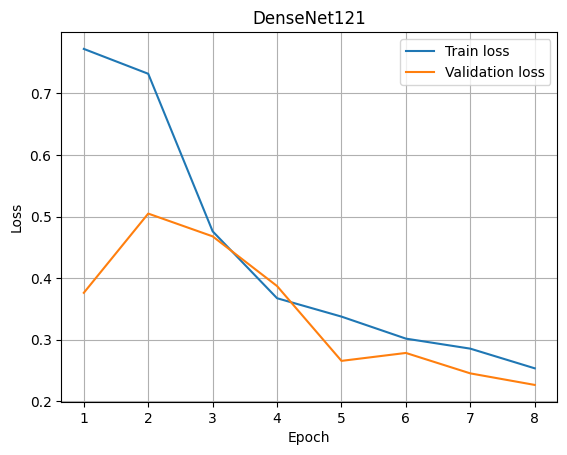

In [61]:
plot_loss_history(dn121_train_losses, dn121_val_losses, title='DenseNet121')

In [73]:
densenet.load_state_dict(torch.load('/kaggle/working/DenseNet121_best_result_augmented.pt'))

<All keys matched successfully>

In [51]:
# densenet.load_state_dict(torch.load('/kaggle/working/DenseNet121_best_result.pt'))

<All keys matched successfully>

In [49]:
# torch.save(densenet.state_dict(), '/kaggle/working/densenet121_full_data.pt')

In [208]:
# torch.save(densenet.state_dict(), '/kaggle/working/densenet_mini_data_with_hagrid.pt')

In [39]:
# torch.save(densenet.state_dict(), '/kaggle/working/densenet_mini_data.pt')

In [84]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
all_labels = np.array([])
all_preds = np.array([])
densenet.eval()
for data in tqdm(testloader):
    images, labels = data
    images = images.to(device)
    labels = labels.to(device)
    # calculate outputs by running images through the network
#         print(images.shape)
    outputs = F.softmax(densenet(images), dim=-1)
#         print(densenet(images).shape)
    # the class with the highest energy is what we choose as prediction
#         print(outputs.data)
#         break
    _, predicted = torch.max(outputs.data, dim=-1)
#         print(predicted.cpu().numpy())
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

    all_labels = np.append(all_labels, labels.cpu().numpy())
    all_preds = np.append(all_preds, predicted.cpu().numpy())

100%|██████████| 327/327 [04:53<00:00,  1.11it/s]


In [85]:
all_preds = all_preds.astype(int)
all_labels = all_labels.astype(int)

In [86]:
all_preds[all_preds == 6] = 1
all_labels[all_labels == 6] = 1

In [87]:
dict(zip(sorted(data_copy['class'].unique()), le.inverse_transform(sorted(data_copy['class'].unique()))))

{0: 'Hand_cellular',
 1: 'Hand_cigarette',
 2: 'Hand_empty',
 3: 'Hand_over_wheel',
 4: 'Hand_under_wheel',
 5: 'Hand_unknown',
 6: 'Hand_vape',
 7: 'Not_hand'}

In [88]:
np.unique(all_preds)

array([0, 1, 2, 3, 4, 5, 7])

In [89]:
unique, counts = np.unique(all_preds, return_counts=True)
dict(zip(unique, counts))

{0: 1478, 1: 491, 2: 1118, 3: 574, 4: 1083, 5: 2643, 7: 3050}

## Подсчет метрик отдельно по классам

In [91]:
target_names = le.inverse_transform(np.unique(all_preds))
print(classification_report(all_labels, all_preds, target_names=target_names, digits=4))

                  precision    recall  f1-score   support

   Hand_cellular     0.9364    0.9886    0.9618      1400
  Hand_cigarette     0.8961    0.9670    0.9302       455
      Hand_empty     0.9258    0.9119    0.9188      1135
 Hand_over_wheel     0.8310    0.9086    0.8681       525
Hand_under_wheel     0.9797    0.9628    0.9712      1102
    Hand_unknown     0.9701    0.9025    0.9351      2841
        Not_hand     0.9695    0.9926    0.9809      2979

        accuracy                         0.9503     10437
       macro avg     0.9298    0.9477    0.9380     10437
    weighted avg     0.9514    0.9503    0.9502     10437



In [72]:
target_names

array(['Hand_cellular', 'Hand_cigarette', 'Hand_empty', 'Hand_over_wheel',
       'Hand_under_wheel', 'Hand_unknown', 'Not_hand'], dtype=object)

<Figure size 2000x400 with 0 Axes>

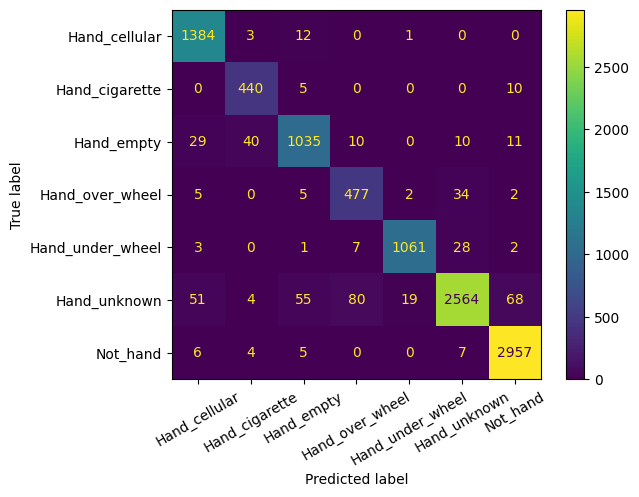

In [92]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(20, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=target_names)
disp.plot()
plt.xticks(rotation=30)
plt.show()

In [74]:
def predict_one_random_image(net, data):
    net.eval()
    dataset_no_transform = DriverHandsDataset(data, ROOT_DIR)
    random_index = random.randint(0, len(dataset_no_transform) - 1) 
  
    plt.imshow(dataset_no_transform[random_index][0])
    true_label = le.inverse_transform([dataset_no_transform[random_index][1].item()])[0]
    
    inp_image = torch.unsqueeze(transform(dataset_no_transform[random_index][0]), dim=0)

    probs = F.softmax(net.cpu()(inp_image), dim=-1)
    
    _, predicted = torch.max(probs.data, dim=-1)
    pred_label = le.inverse_transform([predicted.item()])[0]
    
    plt.title(f'gt: {true_label}, pred: {pred_label}')
    
    plt.show()

In [75]:
# torch.cuda.empty_cache()

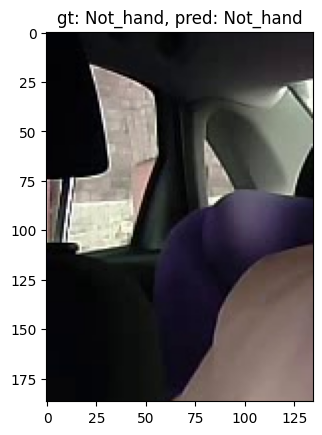

In [82]:
predict_one_random_image(densenet, data_copy)

## Проверка предсказаний модели на кадрах, где нет рук

In [83]:
len(empty_images_paths)

25567

In [36]:
class NoHandsDataset(Dataset):
    def __init__(self, paths: list, root_dir, transform=None):
        self.paths = paths
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.paths[index])
        # image = io.imread(img_path)
        image = Image.open(img_path)
        frame_width, frame_height = image.size
        
        crop_height = random.randint(120, 200)
        crop_width = random.randint(120, 200)
        
        x = random.randint(0, frame_width - crop_width)
        y = random.randint(0, frame_height - crop_height)
        
        crop_area = (x, y, x + crop_width, y + crop_height)
        image = image.crop(crop_area)
        
        if self.transform:
            image = self.transform(image)
            
        return image

In [204]:
no_hands_dataset_no_transform = NoHandsDataset(empty_images_paths[:5000], ROOT_DIR)

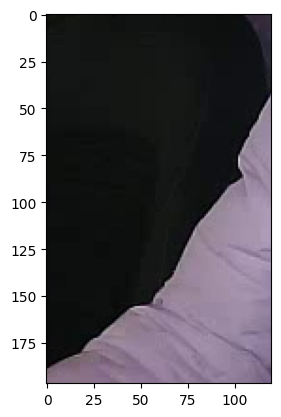

In [205]:
random_index = random.randint(0, len(no_hands_dataset_no_transform) - 1) 
  
# Plotting the randomly selected image 
plt.imshow(no_hands_dataset_no_transform[random_index])
plt.show()

In [206]:
no_hands_dataset = NoHandsDataset(empty_images_paths, ROOT_DIR, transform=transform)

In [207]:
no_hands_loader = DataLoader(no_hands_dataset, batch_size=32,
                                          shuffle=True)

In [46]:
no_hands_preds = np.array([])
densenet = densenet.to(device)
densenet.eval()
for data in tqdm(no_hands_loader):
    images = data
    images = images.to(device)
    # calculate outputs by running images through the network
#         print(images.shape)
    outputs = F.softmax(densenet(images), dim=-1)
#         print(densenet(images).shape)
    # the class with the highest energy is what we choose as prediction
#         print(outputs.data)
#         break
    _, predicted = torch.max(outputs.data, dim=-1)
#         print(predicted.cpu().numpy())

    no_hands_preds = np.append(no_hands_preds, predicted.cpu().numpy())

100%|██████████| 799/799 [09:05<00:00,  1.47it/s]


In [47]:
len(no_hands_preds)

25544

In [48]:
unique, counts = np.unique(no_hands_preds, return_counts=True)

In [49]:
unique = le.inverse_transform(unique.astype(int))

### Количество предсказаний по классам на кадрах без рук

In [50]:
dict(zip(unique, counts))

{'Hand_cellular': 3,
 'Hand_empty': 35,
 'Hand_food': 28,
 'Hand_over_wheel': 3,
 'Hand_unknown': 55,
 'Not_hand': 25420}

# Обучение MobileNetV2

In [62]:
mobilenet = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)
mobilenet.classifier[1] = nn.Linear(1280, n_classes, bias=True)
mobilenet = mobilenet.to(device)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 101MB/s] 


In [39]:
# mobilenet.load_state_dict(torch.load('/kaggle/working/mobilenet_full_data.pt'))

<All keys matched successfully>

In [40]:
# mobilenet.load_state_dict(torch.load('/kaggle/working/mobilenet_mini_data_with_hagrid.pt'))

<All keys matched successfully>

In [63]:
criterion = nn.CrossEntropyLoss(weight=torch.Tensor(list(class_weights.values())).to(device))
optimizer = optim.SGD(mobilenet.parameters(), lr=0.001, momentum=0.9)

In [64]:
mn_train_losses, mn_val_losses = train(mobilenet, criterion, optimizer, model_name='MobileNetV2', n_epochs=8)

  3%|▎         | 20/617 [00:12<06:08,  1.62it/s]

[1,    20] loss: 1.976


  6%|▋         | 40/617 [00:25<06:52,  1.40it/s]

[1,    40] loss: 1.517


 10%|▉         | 60/617 [00:38<05:40,  1.64it/s]

[1,    60] loss: 1.171


 13%|█▎        | 80/617 [00:51<05:40,  1.57it/s]

[1,    80] loss: 1.128


 16%|█▌        | 100/617 [01:04<05:34,  1.55it/s]

[1,   100] loss: 1.095


 19%|█▉        | 120/617 [01:16<04:53,  1.69it/s]

[1,   120] loss: 0.962


 23%|██▎       | 140/617 [01:29<05:04,  1.56it/s]

[1,   140] loss: 0.850


 26%|██▌       | 160/617 [01:42<04:58,  1.53it/s]

[1,   160] loss: 0.764


 29%|██▉       | 180/617 [01:54<04:32,  1.60it/s]

[1,   180] loss: 0.866


 32%|███▏      | 200/617 [02:08<04:45,  1.46it/s]

[1,   200] loss: 0.773


 36%|███▌      | 220/617 [02:21<04:19,  1.53it/s]

[1,   220] loss: 0.728


 39%|███▉      | 240/617 [02:34<04:12,  1.49it/s]

[1,   240] loss: 0.693


 42%|████▏     | 260/617 [02:47<03:53,  1.53it/s]

[1,   260] loss: 0.709


 45%|████▌     | 280/617 [03:00<03:29,  1.61it/s]

[1,   280] loss: 0.695


 49%|████▊     | 300/617 [03:12<03:10,  1.66it/s]

[1,   300] loss: 0.652


 52%|█████▏    | 320/617 [03:25<03:17,  1.50it/s]

[1,   320] loss: 0.679


 55%|█████▌    | 340/617 [03:38<03:04,  1.51it/s]

[1,   340] loss: 0.620


 58%|█████▊    | 360/617 [03:52<02:44,  1.56it/s]

[1,   360] loss: 0.621


 62%|██████▏   | 380/617 [04:04<02:24,  1.64it/s]

[1,   380] loss: 0.573


 65%|██████▍   | 400/617 [04:15<02:00,  1.80it/s]

[1,   400] loss: 0.606


 68%|██████▊   | 420/617 [04:28<02:01,  1.62it/s]

[1,   420] loss: 0.529


 71%|███████▏  | 440/617 [04:40<01:50,  1.61it/s]

[1,   440] loss: 0.632


 75%|███████▍  | 460/617 [04:53<01:27,  1.79it/s]

[1,   460] loss: 0.599


 78%|███████▊  | 480/617 [05:05<01:28,  1.55it/s]

[1,   480] loss: 0.534


 81%|████████  | 500/617 [05:17<01:08,  1.71it/s]

[1,   500] loss: 0.600


 84%|████████▍ | 520/617 [05:29<00:56,  1.71it/s]

[1,   520] loss: 0.519


 88%|████████▊ | 540/617 [05:41<00:51,  1.50it/s]

[1,   540] loss: 0.676


 91%|█████████ | 560/617 [05:54<00:36,  1.57it/s]

[1,   560] loss: 0.486


 94%|█████████▍| 580/617 [06:06<00:22,  1.64it/s]

[1,   580] loss: 0.549


 97%|█████████▋| 600/617 [06:19<00:10,  1.69it/s]

[1,   600] loss: 0.498


100%|██████████| 142/142 [00:53<00:00,  2.63it/s]


[1] val loss: 0.433480060961045
Saving model...


  3%|▎         | 20/617 [00:12<06:05,  1.63it/s]

[2,    20] loss: 1.477


  6%|▋         | 40/617 [00:24<06:17,  1.53it/s]

[2,    40] loss: 1.837


 10%|▉         | 60/617 [00:36<05:43,  1.62it/s]

[2,    60] loss: 1.701


 13%|█▎        | 80/617 [00:47<05:26,  1.64it/s]

[2,    80] loss: 1.396


 16%|█▌        | 100/617 [00:59<05:00,  1.72it/s]

[2,   100] loss: 1.147


 19%|█▉        | 120/617 [01:11<04:45,  1.74it/s]

[2,   120] loss: 1.133


 23%|██▎       | 140/617 [01:23<04:44,  1.68it/s]

[2,   140] loss: 0.842


 26%|██▌       | 160/617 [01:35<04:26,  1.71it/s]

[2,   160] loss: 1.164


 29%|██▉       | 180/617 [01:46<04:10,  1.74it/s]

[2,   180] loss: 1.026


 32%|███▏      | 200/617 [01:58<03:58,  1.75it/s]

[2,   200] loss: 0.873


 36%|███▌      | 220/617 [02:10<04:01,  1.65it/s]

[2,   220] loss: 0.874


 39%|███▉      | 240/617 [02:22<03:53,  1.62it/s]

[2,   240] loss: 0.756


 42%|████▏     | 260/617 [02:34<03:32,  1.68it/s]

[2,   260] loss: 0.865


 45%|████▌     | 280/617 [02:46<03:10,  1.77it/s]

[2,   280] loss: 0.819


 49%|████▊     | 300/617 [02:59<03:27,  1.53it/s]

[2,   300] loss: 0.688


 52%|█████▏    | 320/617 [03:10<03:02,  1.62it/s]

[2,   320] loss: 0.745


 55%|█████▌    | 340/617 [03:22<02:44,  1.68it/s]

[2,   340] loss: 0.696


 58%|█████▊    | 360/617 [03:34<02:22,  1.81it/s]

[2,   360] loss: 0.925


 62%|██████▏   | 380/617 [03:46<02:20,  1.68it/s]

[2,   380] loss: 0.891


 65%|██████▍   | 400/617 [03:58<02:08,  1.69it/s]

[2,   400] loss: 0.834


 68%|██████▊   | 420/617 [04:10<01:49,  1.79it/s]

[2,   420] loss: 0.669


 71%|███████▏  | 440/617 [04:22<01:47,  1.65it/s]

[2,   440] loss: 0.909


 75%|███████▍  | 460/617 [04:34<01:32,  1.70it/s]

[2,   460] loss: 0.711


 78%|███████▊  | 480/617 [04:46<01:21,  1.68it/s]

[2,   480] loss: 0.697


 81%|████████  | 500/617 [04:58<01:16,  1.54it/s]

[2,   500] loss: 0.558


 84%|████████▍ | 520/617 [05:10<01:02,  1.55it/s]

[2,   520] loss: 0.537


 88%|████████▊ | 540/617 [05:22<00:45,  1.69it/s]

[2,   540] loss: 0.683


 91%|█████████ | 560/617 [05:34<00:35,  1.61it/s]

[2,   560] loss: 0.717


 94%|█████████▍| 580/617 [05:46<00:21,  1.71it/s]

[2,   580] loss: 0.556


 97%|█████████▋| 600/617 [05:58<00:10,  1.69it/s]

[2,   600] loss: 0.631


100%|██████████| 142/142 [00:53<00:00,  2.66it/s]


[2] val loss: 0.6100737061089193


  3%|▎         | 20/617 [00:11<05:20,  1.86it/s]

[3,    20] loss: 0.573


  6%|▋         | 40/617 [00:23<05:50,  1.65it/s]

[3,    40] loss: 0.621


 10%|▉         | 60/617 [00:36<06:05,  1.52it/s]

[3,    60] loss: 0.820


 13%|█▎        | 80/617 [00:48<05:15,  1.70it/s]

[3,    80] loss: 0.650


 16%|█▌        | 100/617 [00:59<04:56,  1.74it/s]

[3,   100] loss: 0.550


 19%|█▉        | 120/617 [01:11<04:56,  1.67it/s]

[3,   120] loss: 0.470


 23%|██▎       | 140/617 [01:23<04:37,  1.72it/s]

[3,   140] loss: 0.542


 26%|██▌       | 160/617 [01:35<04:34,  1.66it/s]

[3,   160] loss: 0.697


 29%|██▉       | 180/617 [01:47<04:14,  1.71it/s]

[3,   180] loss: 0.577


 32%|███▏      | 200/617 [01:58<03:57,  1.75it/s]

[3,   200] loss: 0.608


 36%|███▌      | 220/617 [02:10<03:57,  1.67it/s]

[3,   220] loss: 0.519


 39%|███▉      | 240/617 [02:22<03:38,  1.73it/s]

[3,   240] loss: 0.565


 42%|████▏     | 260/617 [02:35<03:30,  1.70it/s]

[3,   260] loss: 0.459


 45%|████▌     | 280/617 [02:47<03:29,  1.61it/s]

[3,   280] loss: 0.572


 49%|████▊     | 300/617 [02:59<03:13,  1.64it/s]

[3,   300] loss: 0.514


 52%|█████▏    | 320/617 [03:11<02:52,  1.72it/s]

[3,   320] loss: 0.493


 55%|█████▌    | 340/617 [03:23<02:54,  1.59it/s]

[3,   340] loss: 0.642


 58%|█████▊    | 360/617 [03:35<02:48,  1.52it/s]

[3,   360] loss: 0.671


 62%|██████▏   | 380/617 [03:47<02:21,  1.68it/s]

[3,   380] loss: 0.597


 65%|██████▍   | 400/617 [03:59<02:09,  1.67it/s]

[3,   400] loss: 0.602


 68%|██████▊   | 420/617 [04:11<02:08,  1.54it/s]

[3,   420] loss: 0.552


 71%|███████▏  | 440/617 [04:23<01:57,  1.51it/s]

[3,   440] loss: 0.473


 75%|███████▍  | 460/617 [04:36<01:35,  1.64it/s]

[3,   460] loss: 0.506


 78%|███████▊  | 480/617 [04:48<01:20,  1.71it/s]

[3,   480] loss: 0.422


 81%|████████  | 500/617 [05:00<01:10,  1.67it/s]

[3,   500] loss: 0.403


 84%|████████▍ | 520/617 [05:12<00:58,  1.65it/s]

[3,   520] loss: 0.459


 88%|████████▊ | 540/617 [05:24<00:48,  1.57it/s]

[3,   540] loss: 0.514


 91%|█████████ | 560/617 [05:36<00:33,  1.71it/s]

[3,   560] loss: 0.717


 94%|█████████▍| 580/617 [05:48<00:22,  1.61it/s]

[3,   580] loss: 0.485


 97%|█████████▋| 600/617 [06:00<00:09,  1.78it/s]

[3,   600] loss: 0.508


100%|██████████| 142/142 [00:53<00:00,  2.67it/s]


[3] val loss: 0.4621487172766471


  3%|▎         | 20/617 [00:11<05:55,  1.68it/s]

[4,    20] loss: 0.581


  6%|▋         | 40/617 [00:23<05:50,  1.65it/s]

[4,    40] loss: 0.630


 10%|▉         | 60/617 [00:35<05:26,  1.70it/s]

[4,    60] loss: 0.554


 13%|█▎        | 80/617 [00:47<05:08,  1.74it/s]

[4,    80] loss: 0.471


 16%|█▌        | 100/617 [00:59<05:09,  1.67it/s]

[4,   100] loss: 0.450


 19%|█▉        | 120/617 [01:11<04:47,  1.73it/s]

[4,   120] loss: 0.507


 23%|██▎       | 140/617 [01:23<04:56,  1.61it/s]

[4,   140] loss: 0.421


 26%|██▌       | 160/617 [01:36<04:27,  1.71it/s]

[4,   160] loss: 0.346


 29%|██▉       | 180/617 [01:48<04:40,  1.56it/s]

[4,   180] loss: 0.440


 32%|███▏      | 200/617 [02:00<04:16,  1.62it/s]

[4,   200] loss: 0.669


 36%|███▌      | 220/617 [02:12<03:42,  1.78it/s]

[4,   220] loss: 0.646


 39%|███▉      | 240/617 [02:24<03:41,  1.70it/s]

[4,   240] loss: 0.404


 42%|████▏     | 260/617 [02:36<03:41,  1.61it/s]

[4,   260] loss: 0.466


 45%|████▌     | 280/617 [02:48<03:34,  1.57it/s]

[4,   280] loss: 0.496


 49%|████▊     | 300/617 [03:01<03:26,  1.54it/s]

[4,   300] loss: 0.534


 52%|█████▏    | 320/617 [03:14<03:04,  1.61it/s]

[4,   320] loss: 0.350


 55%|█████▌    | 340/617 [03:26<03:02,  1.52it/s]

[4,   340] loss: 0.353


 58%|█████▊    | 360/617 [03:39<02:47,  1.53it/s]

[4,   360] loss: 0.417


 62%|██████▏   | 380/617 [03:52<02:31,  1.57it/s]

[4,   380] loss: 0.612


 65%|██████▍   | 400/617 [04:04<02:15,  1.60it/s]

[4,   400] loss: 0.537


 68%|██████▊   | 420/617 [04:17<02:14,  1.46it/s]

[4,   420] loss: 0.446


 71%|███████▏  | 440/617 [04:29<01:50,  1.60it/s]

[4,   440] loss: 0.519


 75%|███████▍  | 460/617 [04:42<01:40,  1.57it/s]

[4,   460] loss: 0.576


 78%|███████▊  | 480/617 [04:55<01:26,  1.58it/s]

[4,   480] loss: 0.445


 81%|████████  | 500/617 [05:08<01:15,  1.55it/s]

[4,   500] loss: 0.424


 84%|████████▍ | 520/617 [05:21<01:00,  1.59it/s]

[4,   520] loss: 0.483


 88%|████████▊ | 540/617 [05:33<00:46,  1.67it/s]

[4,   540] loss: 0.433


 91%|█████████ | 560/617 [05:45<00:34,  1.66it/s]

[4,   560] loss: 0.480


 94%|█████████▍| 580/617 [05:58<00:23,  1.56it/s]

[4,   580] loss: 0.433


 97%|█████████▋| 600/617 [06:11<00:10,  1.64it/s]

[4,   600] loss: 0.453


100%|██████████| 142/142 [00:55<00:00,  2.56it/s]


[4] val loss: 0.43380678020102875


  3%|▎         | 20/617 [00:11<05:46,  1.72it/s]

[5,    20] loss: 0.403


  6%|▋         | 40/617 [00:23<05:45,  1.67it/s]

[5,    40] loss: 0.395


 10%|▉         | 60/617 [00:35<05:12,  1.78it/s]

[5,    60] loss: 0.465


 13%|█▎        | 80/617 [00:48<05:41,  1.57it/s]

[5,    80] loss: 0.416


 16%|█▌        | 100/617 [01:00<04:58,  1.73it/s]

[5,   100] loss: 0.385


 19%|█▉        | 120/617 [01:12<05:04,  1.63it/s]

[5,   120] loss: 0.401


 23%|██▎       | 140/617 [01:24<04:36,  1.73it/s]

[5,   140] loss: 0.407


 26%|██▌       | 160/617 [01:36<04:26,  1.71it/s]

[5,   160] loss: 0.442


 29%|██▉       | 180/617 [01:48<04:18,  1.69it/s]

[5,   180] loss: 0.373


 32%|███▏      | 200/617 [02:00<04:00,  1.73it/s]

[5,   200] loss: 0.335


 36%|███▌      | 220/617 [02:13<03:51,  1.71it/s]

[5,   220] loss: 0.392


 39%|███▉      | 240/617 [02:25<03:38,  1.73it/s]

[5,   240] loss: 0.506


 42%|████▏     | 260/617 [02:36<03:17,  1.80it/s]

[5,   260] loss: 0.411


 45%|████▌     | 280/617 [02:48<03:09,  1.78it/s]

[5,   280] loss: 0.359


 49%|████▊     | 300/617 [03:00<03:04,  1.72it/s]

[5,   300] loss: 0.457


 52%|█████▏    | 320/617 [03:12<02:51,  1.73it/s]

[5,   320] loss: 0.463


 55%|█████▌    | 340/617 [03:24<02:36,  1.76it/s]

[5,   340] loss: 0.403


 58%|█████▊    | 360/617 [03:35<02:23,  1.79it/s]

[5,   360] loss: 0.400


 62%|██████▏   | 380/617 [03:47<02:27,  1.61it/s]

[5,   380] loss: 0.382


 65%|██████▍   | 400/617 [03:59<02:12,  1.64it/s]

[5,   400] loss: 0.360


 68%|██████▊   | 420/617 [04:11<01:54,  1.72it/s]

[5,   420] loss: 0.310


 71%|███████▏  | 440/617 [04:24<01:50,  1.60it/s]

[5,   440] loss: 0.519


 75%|███████▍  | 460/617 [04:35<01:33,  1.69it/s]

[5,   460] loss: 0.546


 78%|███████▊  | 480/617 [04:47<01:23,  1.63it/s]

[5,   480] loss: 0.380


 81%|████████  | 500/617 [04:59<01:15,  1.54it/s]

[5,   500] loss: 0.295


 84%|████████▍ | 520/617 [05:11<00:53,  1.81it/s]

[5,   520] loss: 0.275


 88%|████████▊ | 540/617 [05:23<00:45,  1.69it/s]

[5,   540] loss: 0.454


 91%|█████████ | 560/617 [05:34<00:33,  1.69it/s]

[5,   560] loss: 0.571


 94%|█████████▍| 580/617 [05:46<00:22,  1.66it/s]

[5,   580] loss: 0.403


 97%|█████████▋| 600/617 [05:58<00:10,  1.66it/s]

[5,   600] loss: 0.411


100%|██████████| 142/142 [00:53<00:00,  2.67it/s]


[5] val loss: 0.504240551989683


  3%|▎         | 20/617 [00:11<05:42,  1.74it/s]

[6,    20] loss: 0.432


  6%|▋         | 40/617 [00:23<05:33,  1.73it/s]

[6,    40] loss: 0.457


 10%|▉         | 60/617 [00:35<05:23,  1.72it/s]

[6,    60] loss: 0.346


 13%|█▎        | 80/617 [00:47<05:00,  1.79it/s]

[6,    80] loss: 0.488


 16%|█▌        | 100/617 [00:59<05:10,  1.67it/s]

[6,   100] loss: 0.382


 19%|█▉        | 120/617 [01:11<04:33,  1.82it/s]

[6,   120] loss: 0.533


 23%|██▎       | 140/617 [01:23<04:45,  1.67it/s]

[6,   140] loss: 0.466


 26%|██▌       | 160/617 [01:35<04:26,  1.72it/s]

[6,   160] loss: 0.343


 29%|██▉       | 180/617 [01:47<04:15,  1.71it/s]

[6,   180] loss: 0.361


 32%|███▏      | 200/617 [01:59<04:15,  1.63it/s]

[6,   200] loss: 0.354


 36%|███▌      | 220/617 [02:11<04:07,  1.60it/s]

[6,   220] loss: 0.365


 39%|███▉      | 240/617 [02:23<03:54,  1.60it/s]

[6,   240] loss: 0.544


 42%|████▏     | 260/617 [02:36<03:34,  1.67it/s]

[6,   260] loss: 0.521


 45%|████▌     | 280/617 [02:48<03:23,  1.66it/s]

[6,   280] loss: 0.311


 49%|████▊     | 300/617 [03:01<03:27,  1.53it/s]

[6,   300] loss: 0.347


 52%|█████▏    | 320/617 [03:14<03:09,  1.56it/s]

[6,   320] loss: 0.360


 55%|█████▌    | 340/617 [03:26<02:42,  1.70it/s]

[6,   340] loss: 0.358


 58%|█████▊    | 360/617 [03:39<02:41,  1.59it/s]

[6,   360] loss: 0.450


 62%|██████▏   | 380/617 [03:51<02:31,  1.57it/s]

[6,   380] loss: 0.362


 65%|██████▍   | 400/617 [04:04<02:11,  1.65it/s]

[6,   400] loss: 0.340


 68%|██████▊   | 420/617 [04:17<02:01,  1.62it/s]

[6,   420] loss: 0.332


 71%|███████▏  | 440/617 [04:29<01:55,  1.53it/s]

[6,   440] loss: 0.353


 75%|███████▍  | 460/617 [04:42<01:36,  1.63it/s]

[6,   460] loss: 0.301


 78%|███████▊  | 480/617 [04:54<01:22,  1.67it/s]

[6,   480] loss: 0.294


 81%|████████  | 500/617 [05:06<01:09,  1.68it/s]

[6,   500] loss: 0.327


 84%|████████▍ | 520/617 [05:17<00:53,  1.82it/s]

[6,   520] loss: 0.460


 88%|████████▊ | 540/617 [05:29<00:45,  1.71it/s]

[6,   540] loss: 0.380


 91%|█████████ | 560/617 [05:41<00:33,  1.71it/s]

[6,   560] loss: 0.406


 94%|█████████▍| 580/617 [05:52<00:20,  1.77it/s]

[6,   580] loss: 0.411


 97%|█████████▋| 600/617 [06:04<00:09,  1.76it/s]

[6,   600] loss: 0.339


100%|██████████| 142/142 [00:54<00:00,  2.58it/s]


[6] val loss: 0.6094838840440965


  3%|▎         | 20/617 [00:11<05:45,  1.73it/s]

[7,    20] loss: 0.285


  6%|▋         | 40/617 [00:23<05:25,  1.77it/s]

[7,    40] loss: 0.323


 10%|▉         | 60/617 [00:34<05:05,  1.82it/s]

[7,    60] loss: 0.381


 13%|█▎        | 80/617 [00:45<04:45,  1.88it/s]

[7,    80] loss: 0.438


 16%|█▌        | 100/617 [00:58<05:19,  1.62it/s]

[7,   100] loss: 0.385


 19%|█▉        | 120/617 [01:10<05:00,  1.65it/s]

[7,   120] loss: 0.357


 23%|██▎       | 140/617 [01:22<04:50,  1.64it/s]

[7,   140] loss: 0.335


 26%|██▌       | 160/617 [01:33<04:37,  1.65it/s]

[7,   160] loss: 0.331


 29%|██▉       | 180/617 [01:45<04:22,  1.66it/s]

[7,   180] loss: 0.336


 32%|███▏      | 200/617 [01:58<04:27,  1.56it/s]

[7,   200] loss: 0.357


 36%|███▌      | 220/617 [02:09<03:51,  1.72it/s]

[7,   220] loss: 0.388


 39%|███▉      | 240/617 [02:22<04:11,  1.50it/s]

[7,   240] loss: 0.325


 42%|████▏     | 260/617 [02:34<03:31,  1.69it/s]

[7,   260] loss: 0.352


 45%|████▌     | 280/617 [02:46<03:13,  1.74it/s]

[7,   280] loss: 0.317


 49%|████▊     | 300/617 [02:58<03:23,  1.56it/s]

[7,   300] loss: 0.384


 52%|█████▏    | 320/617 [03:10<02:42,  1.83it/s]

[7,   320] loss: 0.434


 55%|█████▌    | 340/617 [03:21<02:41,  1.71it/s]

[7,   340] loss: 0.200


 58%|█████▊    | 360/617 [03:34<02:34,  1.66it/s]

[7,   360] loss: 0.269


 62%|██████▏   | 380/617 [03:46<02:26,  1.62it/s]

[7,   380] loss: 0.236


 65%|██████▍   | 400/617 [03:58<01:57,  1.85it/s]

[7,   400] loss: 0.273


 68%|██████▊   | 420/617 [04:10<01:54,  1.72it/s]

[7,   420] loss: 0.346


 71%|███████▏  | 440/617 [04:22<01:49,  1.61it/s]

[7,   440] loss: 0.299


 75%|███████▍  | 460/617 [04:34<01:32,  1.69it/s]

[7,   460] loss: 0.280


 78%|███████▊  | 480/617 [04:46<01:23,  1.63it/s]

[7,   480] loss: 0.309


 81%|████████  | 500/617 [04:58<01:04,  1.82it/s]

[7,   500] loss: 0.263


 84%|████████▍ | 520/617 [05:10<00:59,  1.64it/s]

[7,   520] loss: 0.443


 88%|████████▊ | 540/617 [05:21<00:46,  1.65it/s]

[7,   540] loss: 0.350


 91%|█████████ | 560/617 [05:34<00:36,  1.56it/s]

[7,   560] loss: 0.394


 94%|█████████▍| 580/617 [05:47<00:24,  1.50it/s]

[7,   580] loss: 0.346


 97%|█████████▋| 600/617 [05:59<00:10,  1.63it/s]

[7,   600] loss: 0.371


100%|██████████| 142/142 [01:02<00:00,  2.27it/s]


[7] val loss: 0.374091414603549
Saving model...


  3%|▎         | 20/617 [00:13<06:43,  1.48it/s]

[8,    20] loss: 0.274


  6%|▋         | 40/617 [00:27<06:59,  1.38it/s]

[8,    40] loss: 0.284


 10%|▉         | 60/617 [00:41<06:26,  1.44it/s]

[8,    60] loss: 0.322


 13%|█▎        | 80/617 [00:55<05:54,  1.52it/s]

[8,    80] loss: 0.309


 16%|█▌        | 100/617 [01:09<06:20,  1.36it/s]

[8,   100] loss: 0.305


 19%|█▉        | 120/617 [01:22<05:24,  1.53it/s]

[8,   120] loss: 0.289


 23%|██▎       | 140/617 [01:36<05:25,  1.46it/s]

[8,   140] loss: 0.312


 26%|██▌       | 160/617 [01:49<04:50,  1.57it/s]

[8,   160] loss: 0.322


 29%|██▉       | 180/617 [02:03<05:30,  1.32it/s]

[8,   180] loss: 0.333


 32%|███▏      | 200/617 [02:17<04:53,  1.42it/s]

[8,   200] loss: 0.472


 36%|███▌      | 220/617 [02:31<04:43,  1.40it/s]

[8,   220] loss: 0.433


 39%|███▉      | 240/617 [02:45<04:25,  1.42it/s]

[8,   240] loss: 0.320


 42%|████▏     | 260/617 [02:59<04:12,  1.42it/s]

[8,   260] loss: 0.392


 45%|████▌     | 280/617 [03:13<04:05,  1.37it/s]

[8,   280] loss: 0.309


 49%|████▊     | 300/617 [03:27<03:47,  1.40it/s]

[8,   300] loss: 0.350


 52%|█████▏    | 320/617 [03:42<03:32,  1.40it/s]

[8,   320] loss: 0.303


 55%|█████▌    | 340/617 [03:56<03:07,  1.47it/s]

[8,   340] loss: 0.215


 58%|█████▊    | 360/617 [04:10<03:11,  1.34it/s]

[8,   360] loss: 0.241


 62%|██████▏   | 380/617 [04:25<02:49,  1.40it/s]

[8,   380] loss: 0.347


 65%|██████▍   | 400/617 [04:40<02:51,  1.27it/s]

[8,   400] loss: 0.329


 68%|██████▊   | 420/617 [04:54<02:15,  1.45it/s]

[8,   420] loss: 0.404


 71%|███████▏  | 440/617 [05:09<02:22,  1.24it/s]

[8,   440] loss: 0.350


 75%|███████▍  | 460/617 [05:24<02:01,  1.29it/s]

[8,   460] loss: 0.306


 78%|███████▊  | 480/617 [05:39<01:45,  1.30it/s]

[8,   480] loss: 0.238


 81%|████████  | 500/617 [05:54<01:23,  1.41it/s]

[8,   500] loss: 0.248


 84%|████████▍ | 520/617 [06:08<01:15,  1.29it/s]

[8,   520] loss: 0.494


 88%|████████▊ | 540/617 [06:23<00:57,  1.34it/s]

[8,   540] loss: 0.352


 91%|█████████ | 560/617 [06:39<00:44,  1.29it/s]

[8,   560] loss: 0.294


 94%|█████████▍| 580/617 [06:54<00:28,  1.32it/s]

[8,   580] loss: 0.299


 97%|█████████▋| 600/617 [07:09<00:12,  1.38it/s]

[8,   600] loss: 0.396


100%|██████████| 142/142 [01:08<00:00,  2.08it/s]

[8] val loss: 0.3662051662382945
Saving model...
Finished Training


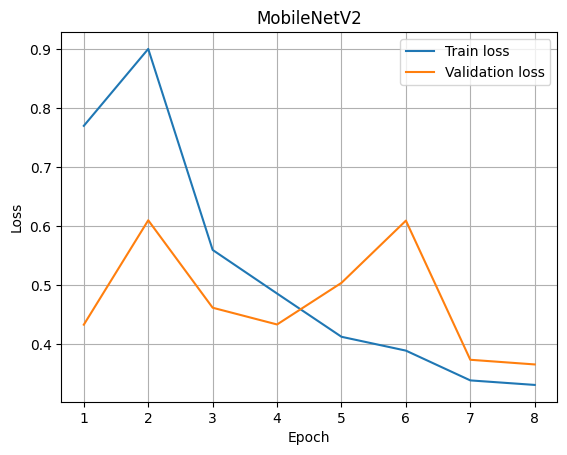

In [65]:
plot_loss_history(mn_train_losses, mn_val_losses, title='MobileNetV2')

In [72]:
mobilenet.load_state_dict(torch.load('/kaggle/working/MobileNetV2_best_result_augmented.pt'))

<All keys matched successfully>

In [59]:
# mobilenet.load_state_dict(torch.load('/kaggle/working/MobileNetV2_best_result.pt'))

<All keys matched successfully>

In [89]:
# torch.save(mobilenet.state_dict(), '/kaggle/working/mobilenet_full_data.pt')

# Обучение DenseNet201

In [66]:
densenet201 = torch.hub.load('pytorch/vision:v0.10.0', 'densenet201', pretrained=True)
densenet201.classifier = nn.Linear(in_features=1920, out_features=n_classes, bias=True)
# densenet201.load_state_dict(torch.load('/kaggle/working/densenet201_mini_data_with_hagrid.pt'))
# densenet201.load_state_dict(torch.load('/kaggle/working/densenet201_full_data.pt'))
densenet201 = densenet201.to(device)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth
100%|██████████| 77.4M/77.4M [00:00<00:00, 140MB/s] 


In [67]:
criterion = nn.CrossEntropyLoss(weight=torch.Tensor(list(class_weights.values())).to(device))
optimizer = optim.SGD(densenet201.parameters(), lr=0.001, momentum=0.9)

In [68]:
dn201_train_losses, dn201_val_losses = train(densenet201, criterion, optimizer, model_name='DenseNet201', n_epochs=8)

  3%|▎         | 20/617 [00:19<09:33,  1.04it/s]

[1,    20] loss: 2.001


  6%|▋         | 40/617 [00:37<08:52,  1.08it/s]

[1,    40] loss: 1.719


 10%|▉         | 60/617 [00:56<08:45,  1.06it/s]

[1,    60] loss: 1.328


 13%|█▎        | 80/617 [01:15<08:11,  1.09it/s]

[1,    80] loss: 1.085


 16%|█▌        | 100/617 [01:33<07:56,  1.09it/s]

[1,   100] loss: 0.941


 19%|█▉        | 120/617 [01:51<07:58,  1.04it/s]

[1,   120] loss: 0.870


 23%|██▎       | 140/617 [02:10<07:14,  1.10it/s]

[1,   140] loss: 1.011


 26%|██▌       | 160/617 [02:29<07:08,  1.07it/s]

[1,   160] loss: 0.830


 29%|██▉       | 180/617 [02:47<06:56,  1.05it/s]

[1,   180] loss: 0.724


 32%|███▏      | 200/617 [03:07<06:25,  1.08it/s]

[1,   200] loss: 0.692


 36%|███▌      | 220/617 [03:25<06:25,  1.03it/s]

[1,   220] loss: 0.522


 39%|███▉      | 240/617 [03:44<06:08,  1.02it/s]

[1,   240] loss: 0.461


 42%|████▏     | 260/617 [04:03<05:32,  1.07it/s]

[1,   260] loss: 0.530


 45%|████▌     | 280/617 [04:22<05:20,  1.05it/s]

[1,   280] loss: 0.616


 49%|████▊     | 300/617 [04:41<05:09,  1.02it/s]

[1,   300] loss: 0.480


 52%|█████▏    | 320/617 [05:00<04:31,  1.09it/s]

[1,   320] loss: 0.522


 55%|█████▌    | 340/617 [05:18<04:02,  1.14it/s]

[1,   340] loss: 0.477


 58%|█████▊    | 360/617 [05:36<03:44,  1.14it/s]

[1,   360] loss: 0.488


 62%|██████▏   | 380/617 [05:55<03:36,  1.10it/s]

[1,   380] loss: 0.459


 65%|██████▍   | 400/617 [06:14<03:26,  1.05it/s]

[1,   400] loss: 0.470


 68%|██████▊   | 420/617 [06:33<03:19,  1.01s/it]

[1,   420] loss: 0.552


 71%|███████▏  | 440/617 [06:52<02:50,  1.04it/s]

[1,   440] loss: 0.483


 75%|███████▍  | 460/617 [07:11<02:26,  1.07it/s]

[1,   460] loss: 0.505


 78%|███████▊  | 480/617 [07:30<02:12,  1.04it/s]

[1,   480] loss: 0.446


 81%|████████  | 500/617 [07:50<01:53,  1.03it/s]

[1,   500] loss: 0.448


 84%|████████▍ | 520/617 [08:09<01:36,  1.01it/s]

[1,   520] loss: 0.331


 88%|████████▊ | 540/617 [08:28<01:15,  1.02it/s]

[1,   540] loss: 0.470


 91%|█████████ | 560/617 [08:48<00:55,  1.02it/s]

[1,   560] loss: 0.472


 94%|█████████▍| 580/617 [09:07<00:35,  1.05it/s]

[1,   580] loss: 0.545


 97%|█████████▋| 600/617 [09:27<00:16,  1.03it/s]

[1,   600] loss: 0.460


100%|██████████| 142/142 [01:19<00:00,  1.78it/s]


[1] val loss: 0.2894129059474233
Saving model...


  3%|▎         | 20/617 [00:18<09:56,  1.00it/s]

[2,    20] loss: 0.723


  6%|▋         | 40/617 [00:37<09:04,  1.06it/s]

[2,    40] loss: 1.157


 10%|▉         | 60/617 [00:57<09:14,  1.00it/s]

[2,    60] loss: 1.192


 13%|█▎        | 80/617 [01:16<08:49,  1.01it/s]

[2,    80] loss: 1.053


 16%|█▌        | 100/617 [01:34<07:47,  1.11it/s]

[2,   100] loss: 0.991


 19%|█▉        | 120/617 [01:53<08:06,  1.02it/s]

[2,   120] loss: 0.956


 23%|██▎       | 140/617 [02:13<07:15,  1.10it/s]

[2,   140] loss: 0.798


 26%|██▌       | 160/617 [02:32<07:21,  1.04it/s]

[2,   160] loss: 0.748


 29%|██▉       | 180/617 [02:51<07:12,  1.01it/s]

[2,   180] loss: 0.705


 32%|███▏      | 200/617 [03:10<06:29,  1.07it/s]

[2,   200] loss: 0.584


 36%|███▌      | 220/617 [03:29<06:03,  1.09it/s]

[2,   220] loss: 0.563


 39%|███▉      | 240/617 [03:47<05:24,  1.16it/s]

[2,   240] loss: 0.647


 42%|████▏     | 260/617 [04:07<05:25,  1.10it/s]

[2,   260] loss: 0.432


 45%|████▌     | 280/617 [04:25<05:20,  1.05it/s]

[2,   280] loss: 0.804


 49%|████▊     | 300/617 [04:45<05:04,  1.04it/s]

[2,   300] loss: 0.664


 52%|█████▏    | 320/617 [05:04<04:32,  1.09it/s]

[2,   320] loss: 0.401


 55%|█████▌    | 340/617 [05:23<04:20,  1.06it/s]

[2,   340] loss: 0.598


 58%|█████▊    | 360/617 [05:42<03:56,  1.09it/s]

[2,   360] loss: 0.590


 62%|██████▏   | 380/617 [06:01<03:34,  1.10it/s]

[2,   380] loss: 0.502


 65%|██████▍   | 400/617 [06:20<03:18,  1.09it/s]

[2,   400] loss: 0.498


 68%|██████▊   | 420/617 [06:39<03:07,  1.05it/s]

[2,   420] loss: 0.480


 71%|███████▏  | 440/617 [06:58<02:51,  1.03it/s]

[2,   440] loss: 0.418


 75%|███████▍  | 460/617 [07:17<02:27,  1.07it/s]

[2,   460] loss: 0.904


 78%|███████▊  | 480/617 [07:36<02:12,  1.03it/s]

[2,   480] loss: 0.649


 81%|████████  | 500/617 [07:56<01:58,  1.02s/it]

[2,   500] loss: 0.467


 84%|████████▍ | 520/617 [08:15<01:27,  1.10it/s]

[2,   520] loss: 0.850


 88%|████████▊ | 540/617 [08:35<01:14,  1.03it/s]

[2,   540] loss: 0.638


 91%|█████████ | 560/617 [08:54<00:54,  1.04it/s]

[2,   560] loss: 0.495


 94%|█████████▍| 580/617 [09:14<00:36,  1.01it/s]

[2,   580] loss: 0.528


 97%|█████████▋| 600/617 [09:33<00:15,  1.07it/s]

[2,   600] loss: 0.357


100%|██████████| 142/142 [01:17<00:00,  1.82it/s]


[2] val loss: 0.3695243051879003


  3%|▎         | 20/617 [00:19<09:38,  1.03it/s]

[3,    20] loss: 0.462


  6%|▋         | 40/617 [00:38<09:10,  1.05it/s]

[3,    40] loss: 0.430


 10%|▉         | 60/617 [00:57<08:35,  1.08it/s]

[3,    60] loss: 0.335


 13%|█▎        | 80/617 [01:16<08:29,  1.05it/s]

[3,    80] loss: 0.365


 16%|█▌        | 100/617 [01:34<07:48,  1.10it/s]

[3,   100] loss: 0.463


 19%|█▉        | 120/617 [01:53<08:06,  1.02it/s]

[3,   120] loss: 0.374


 23%|██▎       | 140/617 [02:12<06:50,  1.16it/s]

[3,   140] loss: 0.468


 26%|██▌       | 160/617 [02:31<07:22,  1.03it/s]

[3,   160] loss: 0.527


 29%|██▉       | 180/617 [02:50<06:54,  1.05it/s]

[3,   180] loss: 0.324


 32%|███▏      | 200/617 [03:09<06:29,  1.07it/s]

[3,   200] loss: 0.336


 36%|███▌      | 220/617 [03:27<06:09,  1.08it/s]

[3,   220] loss: 0.447


 39%|███▉      | 240/617 [03:47<05:47,  1.09it/s]

[3,   240] loss: 0.350


 42%|████▏     | 260/617 [04:05<05:28,  1.09it/s]

[3,   260] loss: 0.426


 45%|████▌     | 280/617 [04:23<05:12,  1.08it/s]

[3,   280] loss: 0.388


 49%|████▊     | 300/617 [04:43<04:50,  1.09it/s]

[3,   300] loss: 0.347


 52%|█████▏    | 320/617 [05:01<04:33,  1.09it/s]

[3,   320] loss: 0.384


 55%|█████▌    | 340/617 [05:20<04:10,  1.10it/s]

[3,   340] loss: 0.396


 58%|█████▊    | 360/617 [05:38<03:51,  1.11it/s]

[3,   360] loss: 0.276


 62%|██████▏   | 380/617 [05:56<03:40,  1.08it/s]

[3,   380] loss: 0.576


 65%|██████▍   | 400/617 [06:15<03:28,  1.04it/s]

[3,   400] loss: 0.356


 68%|██████▊   | 420/617 [06:35<03:11,  1.03it/s]

[3,   420] loss: 0.363


 71%|███████▏  | 440/617 [06:53<02:51,  1.03it/s]

[3,   440] loss: 0.389


 75%|███████▍  | 460/617 [07:12<02:32,  1.03it/s]

[3,   460] loss: 0.314


 78%|███████▊  | 480/617 [07:31<02:07,  1.08it/s]

[3,   480] loss: 0.266


 81%|████████  | 500/617 [07:49<01:44,  1.11it/s]

[3,   500] loss: 0.259


 84%|████████▍ | 520/617 [08:08<01:33,  1.04it/s]

[3,   520] loss: 0.363


 88%|████████▊ | 540/617 [08:27<01:13,  1.04it/s]

[3,   540] loss: 0.269


 91%|█████████ | 560/617 [08:46<00:55,  1.02it/s]

[3,   560] loss: 0.329


 94%|█████████▍| 580/617 [09:05<00:34,  1.09it/s]

[3,   580] loss: 0.413


 97%|█████████▋| 600/617 [09:24<00:16,  1.01it/s]

[3,   600] loss: 0.468


100%|██████████| 142/142 [01:18<00:00,  1.81it/s]


[3] val loss: 0.347896353039943


  3%|▎         | 20/617 [00:18<09:14,  1.08it/s]

[4,    20] loss: 0.392


  6%|▋         | 40/617 [00:37<09:16,  1.04it/s]

[4,    40] loss: 0.284


 10%|▉         | 60/617 [00:56<08:32,  1.09it/s]

[4,    60] loss: 0.284


 13%|█▎        | 80/617 [01:15<08:32,  1.05it/s]

[4,    80] loss: 0.251


 16%|█▌        | 100/617 [01:33<07:49,  1.10it/s]

[4,   100] loss: 0.251


 19%|█▉        | 120/617 [01:53<07:59,  1.04it/s]

[4,   120] loss: 0.339


 23%|██▎       | 140/617 [02:12<07:51,  1.01it/s]

[4,   140] loss: 0.249


 26%|██▌       | 160/617 [02:31<07:29,  1.02it/s]

[4,   160] loss: 0.288


 29%|██▉       | 180/617 [02:50<07:02,  1.03it/s]

[4,   180] loss: 0.329


 32%|███▏      | 200/617 [03:08<06:58,  1.00s/it]

[4,   200] loss: 0.389


 36%|███▌      | 220/617 [03:28<06:35,  1.00it/s]

[4,   220] loss: 0.258


 39%|███▉      | 240/617 [03:47<05:48,  1.08it/s]

[4,   240] loss: 0.287


 42%|████▏     | 260/617 [04:06<05:30,  1.08it/s]

[4,   260] loss: 0.329


 45%|████▌     | 280/617 [04:25<05:02,  1.11it/s]

[4,   280] loss: 0.269


 49%|████▊     | 300/617 [04:44<04:58,  1.06it/s]

[4,   300] loss: 0.344


 52%|█████▏    | 320/617 [05:03<04:31,  1.09it/s]

[4,   320] loss: 0.301


 55%|█████▌    | 340/617 [05:22<04:31,  1.02it/s]

[4,   340] loss: 0.183


 58%|█████▊    | 360/617 [05:41<03:59,  1.07it/s]

[4,   360] loss: 0.303


 62%|██████▏   | 380/617 [06:01<03:54,  1.01it/s]

[4,   380] loss: 0.482


 65%|██████▍   | 400/617 [06:20<03:26,  1.05it/s]

[4,   400] loss: 0.346


 68%|██████▊   | 420/617 [06:40<03:11,  1.03it/s]

[4,   420] loss: 0.405


 71%|███████▏  | 440/617 [06:59<02:45,  1.07it/s]

[4,   440] loss: 0.266


 75%|███████▍  | 460/617 [07:19<02:34,  1.01it/s]

[4,   460] loss: 0.285


 78%|███████▊  | 480/617 [07:39<02:19,  1.02s/it]

[4,   480] loss: 0.283


 81%|████████  | 500/617 [07:59<01:58,  1.01s/it]

[4,   500] loss: 0.335


 84%|████████▍ | 520/617 [08:18<01:33,  1.04it/s]

[4,   520] loss: 0.276


 88%|████████▊ | 540/617 [08:37<01:13,  1.04it/s]

[4,   540] loss: 0.270


 91%|█████████ | 560/617 [08:57<00:54,  1.05it/s]

[4,   560] loss: 0.316


 94%|█████████▍| 580/617 [09:16<00:35,  1.04it/s]

[4,   580] loss: 0.362


 97%|█████████▋| 600/617 [09:35<00:16,  1.04it/s]

[4,   600] loss: 0.362


100%|██████████| 142/142 [01:21<00:00,  1.75it/s]


[4] val loss: 0.22754877392517428
Saving model...


  3%|▎         | 20/617 [00:19<09:17,  1.07it/s]

[5,    20] loss: 0.298


  6%|▋         | 40/617 [00:37<08:41,  1.11it/s]

[5,    40] loss: 0.273


 10%|▉         | 60/617 [00:56<08:42,  1.07it/s]

[5,    60] loss: 0.282


 13%|█▎        | 80/617 [01:16<08:40,  1.03it/s]

[5,    80] loss: 0.315


 16%|█▌        | 100/617 [01:35<08:48,  1.02s/it]

[5,   100] loss: 0.267


 19%|█▉        | 120/617 [01:55<08:04,  1.03it/s]

[5,   120] loss: 0.206


 23%|██▎       | 140/617 [02:15<08:02,  1.01s/it]

[5,   140] loss: 0.336


 26%|██▌       | 160/617 [02:33<07:01,  1.08it/s]

[5,   160] loss: 0.287


 29%|██▉       | 180/617 [02:53<07:04,  1.03it/s]

[5,   180] loss: 0.219


 32%|███▏      | 200/617 [03:12<06:34,  1.06it/s]

[5,   200] loss: 0.279


 36%|███▌      | 220/617 [03:32<06:25,  1.03it/s]

[5,   220] loss: 0.314


 39%|███▉      | 240/617 [03:51<05:50,  1.07it/s]

[5,   240] loss: 0.254


 42%|████▏     | 260/617 [04:10<05:38,  1.05it/s]

[5,   260] loss: 0.218


 45%|████▌     | 280/617 [04:30<05:29,  1.02it/s]

[5,   280] loss: 0.372


 49%|████▊     | 300/617 [04:49<05:02,  1.05it/s]

[5,   300] loss: 0.342


 52%|█████▏    | 320/617 [05:08<04:37,  1.07it/s]

[5,   320] loss: 0.329


 55%|█████▌    | 340/617 [05:27<04:11,  1.10it/s]

[5,   340] loss: 0.228


 58%|█████▊    | 360/617 [05:46<04:19,  1.01s/it]

[5,   360] loss: 0.343


 62%|██████▏   | 380/617 [06:05<03:40,  1.07it/s]

[5,   380] loss: 0.382


 65%|██████▍   | 400/617 [06:24<03:28,  1.04it/s]

[5,   400] loss: 0.330


 68%|██████▊   | 420/617 [06:43<02:59,  1.10it/s]

[5,   420] loss: 0.151


 71%|███████▏  | 440/617 [07:03<02:48,  1.05it/s]

[5,   440] loss: 0.306


 75%|███████▍  | 460/617 [07:22<02:35,  1.01it/s]

[5,   460] loss: 0.271


 78%|███████▊  | 480/617 [07:42<02:10,  1.05it/s]

[5,   480] loss: 0.189


 81%|████████  | 500/617 [08:01<01:59,  1.02s/it]

[5,   500] loss: 0.209


 84%|████████▍ | 520/617 [08:21<01:36,  1.00it/s]

[5,   520] loss: 0.306


 88%|████████▊ | 540/617 [08:40<01:13,  1.04it/s]

[5,   540] loss: 0.358


 91%|█████████ | 560/617 [09:00<00:56,  1.00it/s]

[5,   560] loss: 0.244


 94%|█████████▍| 580/617 [09:19<00:34,  1.07it/s]

[5,   580] loss: 0.232


 97%|█████████▋| 600/617 [09:39<00:17,  1.01s/it]

[5,   600] loss: 0.274


100%|██████████| 142/142 [01:18<00:00,  1.82it/s]


[5] val loss: 0.3001688885909151


  3%|▎         | 20/617 [00:18<09:16,  1.07it/s]

[6,    20] loss: 0.261


  6%|▋         | 40/617 [00:38<09:17,  1.03it/s]

[6,    40] loss: 0.210


 10%|▉         | 60/617 [00:56<08:26,  1.10it/s]

[6,    60] loss: 0.211


 13%|█▎        | 80/617 [01:15<08:17,  1.08it/s]

[6,    80] loss: 0.263


 16%|█▌        | 100/617 [01:33<08:04,  1.07it/s]

[6,   100] loss: 0.350


 19%|█▉        | 120/617 [01:52<08:01,  1.03it/s]

[6,   120] loss: 0.227


 23%|██▎       | 140/617 [02:11<07:12,  1.10it/s]

[6,   140] loss: 0.174


 26%|██▌       | 160/617 [02:30<07:11,  1.06it/s]

[6,   160] loss: 0.171


 29%|██▉       | 180/617 [02:49<06:48,  1.07it/s]

[6,   180] loss: 0.169


 32%|███▏      | 200/617 [03:07<06:05,  1.14it/s]

[6,   200] loss: 0.190


 36%|███▌      | 220/617 [03:26<06:15,  1.06it/s]

[6,   220] loss: 0.202


 39%|███▉      | 240/617 [03:45<06:06,  1.03it/s]

[6,   240] loss: 0.217


 42%|████▏     | 260/617 [04:04<05:29,  1.08it/s]

[6,   260] loss: 0.205


 45%|████▌     | 280/617 [04:23<05:34,  1.01it/s]

[6,   280] loss: 0.333


 49%|████▊     | 300/617 [04:42<04:59,  1.06it/s]

[6,   300] loss: 0.211


 52%|█████▏    | 320/617 [05:01<04:25,  1.12it/s]

[6,   320] loss: 0.208


 55%|█████▌    | 340/617 [05:19<04:18,  1.07it/s]

[6,   340] loss: 0.212


 58%|█████▊    | 360/617 [05:38<03:59,  1.07it/s]

[6,   360] loss: 0.290


 62%|██████▏   | 380/617 [05:57<03:46,  1.05it/s]

[6,   380] loss: 0.177


 65%|██████▍   | 400/617 [06:16<03:14,  1.11it/s]

[6,   400] loss: 0.187


 68%|██████▊   | 420/617 [06:35<03:04,  1.07it/s]

[6,   420] loss: 0.215


 71%|███████▏  | 440/617 [06:53<02:45,  1.07it/s]

[6,   440] loss: 0.159


 75%|███████▍  | 460/617 [07:12<02:24,  1.08it/s]

[6,   460] loss: 0.210


 78%|███████▊  | 480/617 [07:31<02:09,  1.06it/s]

[6,   480] loss: 0.220


 81%|████████  | 500/617 [07:49<01:47,  1.09it/s]

[6,   500] loss: 0.247


 84%|████████▍ | 520/617 [08:08<01:37,  1.01s/it]

[6,   520] loss: 0.256


 88%|████████▊ | 540/617 [08:27<01:12,  1.06it/s]

[6,   540] loss: 0.235


 91%|█████████ | 560/617 [08:46<00:53,  1.06it/s]

[6,   560] loss: 0.266


 94%|█████████▍| 580/617 [09:05<00:35,  1.05it/s]

[6,   580] loss: 0.219


 97%|█████████▋| 600/617 [09:25<00:15,  1.06it/s]

[6,   600] loss: 0.188


100%|██████████| 142/142 [01:16<00:00,  1.85it/s]


[6] val loss: 0.2855070473258974


  3%|▎         | 20/617 [00:18<09:30,  1.05it/s]

[7,    20] loss: 0.281


  6%|▋         | 40/617 [00:36<08:59,  1.07it/s]

[7,    40] loss: 0.213


 10%|▉         | 60/617 [00:55<08:53,  1.04it/s]

[7,    60] loss: 0.225


 13%|█▎        | 80/617 [01:14<08:13,  1.09it/s]

[7,    80] loss: 0.177


 16%|█▌        | 100/617 [01:33<08:20,  1.03it/s]

[7,   100] loss: 0.236


 19%|█▉        | 120/617 [01:51<07:43,  1.07it/s]

[7,   120] loss: 0.191


 23%|██▎       | 140/617 [02:11<07:44,  1.03it/s]

[7,   140] loss: 0.162


 26%|██▌       | 160/617 [02:30<07:31,  1.01it/s]

[7,   160] loss: 0.267


 29%|██▉       | 180/617 [02:49<06:58,  1.04it/s]

[7,   180] loss: 0.198


 32%|███▏      | 200/617 [03:09<06:38,  1.05it/s]

[7,   200] loss: 0.224


 36%|███▌      | 220/617 [03:28<06:26,  1.03it/s]

[7,   220] loss: 0.176


 39%|███▉      | 240/617 [03:48<06:19,  1.01s/it]

[7,   240] loss: 0.161


 42%|████▏     | 260/617 [04:07<05:39,  1.05it/s]

[7,   260] loss: 0.247


 45%|████▌     | 280/617 [04:27<05:31,  1.02it/s]

[7,   280] loss: 0.215


 49%|████▊     | 300/617 [04:46<05:02,  1.05it/s]

[7,   300] loss: 0.211


 52%|█████▏    | 320/617 [05:05<04:40,  1.06it/s]

[7,   320] loss: 0.208


 55%|█████▌    | 340/617 [05:23<04:05,  1.13it/s]

[7,   340] loss: 0.326


 58%|█████▊    | 360/617 [05:42<04:03,  1.06it/s]

[7,   360] loss: 0.221


 62%|██████▏   | 380/617 [06:01<03:51,  1.02it/s]

[7,   380] loss: 0.202


 65%|██████▍   | 400/617 [06:20<03:28,  1.04it/s]

[7,   400] loss: 0.143


 68%|██████▊   | 420/617 [06:39<03:06,  1.05it/s]

[7,   420] loss: 0.157


 71%|███████▏  | 440/617 [06:58<02:45,  1.07it/s]

[7,   440] loss: 0.170


 75%|███████▍  | 460/617 [07:17<02:28,  1.05it/s]

[7,   460] loss: 0.199


 78%|███████▊  | 480/617 [07:37<02:13,  1.03it/s]

[7,   480] loss: 0.298


 81%|████████  | 500/617 [07:56<01:52,  1.04it/s]

[7,   500] loss: 0.197


 84%|████████▍ | 520/617 [08:14<01:34,  1.03it/s]

[7,   520] loss: 0.147


 88%|████████▊ | 540/617 [08:33<01:12,  1.06it/s]

[7,   540] loss: 0.165


 91%|█████████ | 560/617 [08:53<00:54,  1.04it/s]

[7,   560] loss: 0.217


 94%|█████████▍| 580/617 [09:12<00:36,  1.02it/s]

[7,   580] loss: 0.171


 97%|█████████▋| 600/617 [09:31<00:15,  1.07it/s]

[7,   600] loss: 0.164


100%|██████████| 142/142 [01:18<00:00,  1.81it/s]


[7] val loss: 0.29484974922166324


  3%|▎         | 20/617 [00:19<10:09,  1.02s/it]

[8,    20] loss: 0.270


  6%|▋         | 40/617 [00:38<09:30,  1.01it/s]

[8,    40] loss: 0.184


 10%|▉         | 60/617 [00:57<08:55,  1.04it/s]

[8,    60] loss: 0.282


 13%|█▎        | 80/617 [01:16<08:02,  1.11it/s]

[8,    80] loss: 0.185


 16%|█▌        | 100/617 [01:35<08:15,  1.04it/s]

[8,   100] loss: 0.192


 19%|█▉        | 120/617 [01:54<07:51,  1.05it/s]

[8,   120] loss: 0.271


 23%|██▎       | 140/617 [02:12<07:03,  1.13it/s]

[8,   140] loss: 0.234


 26%|██▌       | 160/617 [02:31<07:09,  1.06it/s]

[8,   160] loss: 0.318


 29%|██▉       | 180/617 [02:51<07:00,  1.04it/s]

[8,   180] loss: 0.235


 32%|███▏      | 200/617 [03:10<06:36,  1.05it/s]

[8,   200] loss: 0.216


 36%|███▌      | 220/617 [03:28<05:58,  1.11it/s]

[8,   220] loss: 0.311


 39%|███▉      | 240/617 [03:47<05:57,  1.05it/s]

[8,   240] loss: 0.185


 42%|████▏     | 260/617 [04:07<05:26,  1.09it/s]

[8,   260] loss: 0.157


 45%|████▌     | 280/617 [04:26<05:25,  1.04it/s]

[8,   280] loss: 0.159


 49%|████▊     | 300/617 [04:44<04:58,  1.06it/s]

[8,   300] loss: 0.292


 52%|█████▏    | 320/617 [05:04<04:48,  1.03it/s]

[8,   320] loss: 0.179


 55%|█████▌    | 340/617 [05:22<04:25,  1.04it/s]

[8,   340] loss: 0.147


 58%|█████▊    | 360/617 [05:42<04:01,  1.06it/s]

[8,   360] loss: 0.193


 62%|██████▏   | 380/617 [06:00<03:36,  1.09it/s]

[8,   380] loss: 0.147


 65%|██████▍   | 400/617 [06:20<03:21,  1.08it/s]

[8,   400] loss: 0.106


 68%|██████▊   | 420/617 [06:39<03:14,  1.01it/s]

[8,   420] loss: 0.140


 71%|███████▏  | 440/617 [06:59<02:50,  1.04it/s]

[8,   440] loss: 0.223


 75%|███████▍  | 460/617 [07:17<02:31,  1.04it/s]

[8,   460] loss: 0.298


 78%|███████▊  | 480/617 [07:36<02:05,  1.09it/s]

[8,   480] loss: 0.193


 81%|████████  | 500/617 [07:55<01:53,  1.03it/s]

[8,   500] loss: 0.203


 84%|████████▍ | 520/617 [08:15<01:37,  1.01s/it]

[8,   520] loss: 0.182


 88%|████████▊ | 540/617 [08:34<01:12,  1.07it/s]

[8,   540] loss: 0.124


 91%|█████████ | 560/617 [08:53<00:53,  1.06it/s]

[8,   560] loss: 0.155


 94%|█████████▍| 580/617 [09:12<00:36,  1.00it/s]

[8,   580] loss: 0.205


 97%|█████████▋| 600/617 [09:32<00:17,  1.01s/it]

[8,   600] loss: 0.155


100%|██████████| 142/142 [01:17<00:00,  1.83it/s]

[8] val loss: 0.27985308729899183
Finished Training


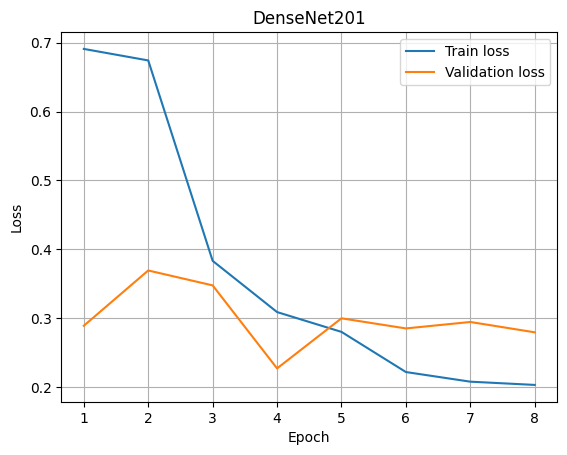

In [70]:
plot_loss_history(dn201_train_losses, dn201_val_losses, title='DenseNet201')

In [71]:
densenet201.load_state_dict(torch.load('/kaggle/working/DenseNet201_best_result_augmented.pt'))

<All keys matched successfully>

In [49]:
# densenet201.load_state_dict(torch.load('/kaggle/working/DenseNet201_best_result.pt'))

<All keys matched successfully>

In [93]:
# torch.save(densenet201.state_dict(), '/kaggle/working/densenet201_full_data.pt')

In [56]:
# torch.save(densenet201.state_dict(), '/kaggle/working/densenet201_mini_data_with_hagrid.pt')

# Подсчет метрик моделей на тестовой выборке и их сравнение

In [74]:
def test_inference(model):
    '''Returns labels, predictions and probabilities of classes for each sample'''
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    all_labels = np.array([])
    all_preds = np.array([])
    all_proba = np.array([])
    model.eval()
    for data in tqdm(testloader):
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        # calculate outputs by running images through the network
    #         print(images.shape)
        outputs = F.softmax(model(images), dim=-1)
    #         print(densenet(images).shape)
        # the class with the highest energy is what we choose as prediction
    #         print(outputs.data)
    #         break
        _, predicted = torch.max(outputs.data, dim=-1)
    #         print(predicted.cpu().numpy())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_labels = np.append(all_labels, labels.cpu().numpy())
        all_preds = np.append(all_preds, predicted.cpu().numpy())
        all_proba = np.append(all_proba, outputs.detach().cpu().numpy())
        
    return all_labels, all_preds, all_proba

In [62]:
# target_names = le.inverse_transform(range(0, n_classes))

In [75]:
def plot_confusion_matrix(labels, preds, title):
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(20, 4))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=target_names)
    disp.plot()
    plt.xticks(rotation=30)
    plt.title(title)
    plt.show()

In [76]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_auc_score

def plot_roc_auc(labels, proba):
    proba = proba.reshape((9985, 6))
    lb = LabelBinarizer()
    labels_one_hot = lb.fit_transform(labels)
    
#     print(labels_one_hot)
#     print(proba.ravel())
    
    display = RocCurveDisplay.from_predictions(
    labels_one_hot.ravel(),
    proba.ravel(),
    name="micro-average OvR",
    color="darkorange"
    )
    
    _ = display.ax_.set(
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title="Micro-averaged One-vs-Rest\nReceiver Operating Characteristic",
    )
    

In [77]:
labels, dn121_preds, dn121_proba = test_inference(densenet)

100%|██████████| 381/381 [05:20<00:00,  1.19it/s]


In [78]:
_, mn_preds, mn_proba = test_inference(mobilenet)

100%|██████████| 381/381 [02:57<00:00,  2.14it/s]


In [79]:
_, dn201_preds, dn201_proba = test_inference(densenet201)

100%|██████████| 381/381 [03:22<00:00,  1.88it/s]


In [80]:
np.unique(labels).astype(int)

array([0, 1, 2, 3, 4, 5, 6, 7])

In [81]:
labels[labels == 6] = 1
dn121_preds[dn121_preds == 6] = 1
mn_preds[mn_preds == 6] = 1
dn201_preds[dn201_preds == 6] = 1
target_names = le.inverse_transform(np.unique(labels).astype(int))

In [82]:
print('MobileNet metrics:')
print(classification_report(labels, mn_preds, target_names=target_names, digits=4))

MobileNet metrics:
                  precision    recall  f1-score   support

   Hand_cellular     0.9055    0.9650    0.9343      1629
  Hand_cigarette     0.7523    0.9347    0.8336       536
      Hand_empty     0.9115    0.8501    0.8797      1321
 Hand_over_wheel     0.8372    0.8507    0.8439       556
Hand_under_wheel     0.7767    0.9826    0.8676      1267
    Hand_unknown     0.9406    0.8064    0.8683      3336
        Not_hand     0.9374    0.9329    0.9351      3532

        accuracy                         0.8950     12177
       macro avg     0.8659    0.9032    0.8804     12177
    weighted avg     0.9017    0.8950    0.8951     12177



In [83]:
print('DenseNet121 metrics:')
print(classification_report(labels, dn121_preds, target_names=target_names, digits=4))

DenseNet121 metrics:
                  precision    recall  f1-score   support

   Hand_cellular     0.9289    0.9779    0.9528      1629
  Hand_cigarette     0.8972    0.9440    0.9200       536
      Hand_empty     0.9641    0.8547    0.9061      1321
 Hand_over_wheel     0.7369    0.9622    0.8346       556
Hand_under_wheel     0.9800    0.9653    0.9726      1267
    Hand_unknown     0.9211    0.9104    0.9157      3336
        Not_hand     0.9734    0.9524    0.9628      3532

        accuracy                         0.9351     12177
       macro avg     0.9145    0.9381    0.9235     12177
    weighted avg     0.9386    0.9351    0.9357     12177



In [84]:
print('DenseNet201 metrics:')
print(classification_report(labels, dn201_preds, target_names=target_names, digits=4))

DenseNet201 metrics:
                  precision    recall  f1-score   support

   Hand_cellular     0.9202    0.9840    0.9511      1629
  Hand_cigarette     0.9741    0.9123    0.9422       536
      Hand_empty     0.9096    0.9069    0.9083      1321
 Hand_over_wheel     0.7470    0.9029    0.8176       556
Hand_under_wheel     0.9402    0.9795    0.9594      1267
    Hand_unknown     0.9405    0.8867    0.9128      3336
        Not_hand     0.9736    0.9589    0.9662      3532

        accuracy                         0.9344     12177
       macro avg     0.9150    0.9330    0.9225     12177
    weighted avg     0.9366    0.9344    0.9347     12177



<Figure size 2000x400 with 0 Axes>

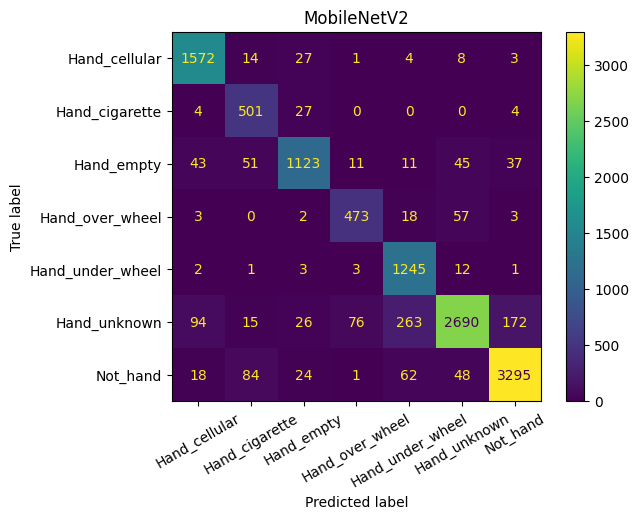

In [85]:
plot_confusion_matrix(labels, mn_preds, title='MobileNetV2')

<Figure size 2000x400 with 0 Axes>

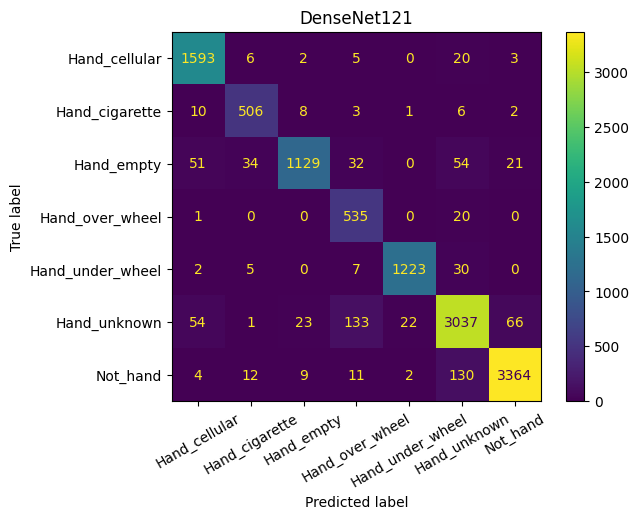

In [86]:
plot_confusion_matrix(labels, dn121_preds, title='DenseNet121')

<Figure size 2000x400 with 0 Axes>

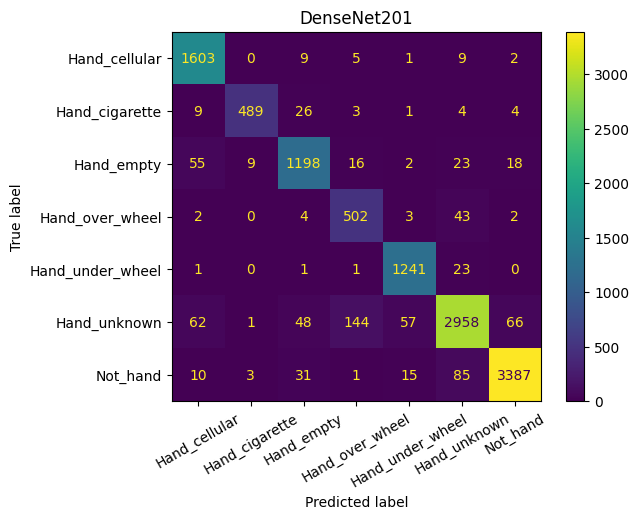

In [87]:
plot_confusion_matrix(labels, dn201_preds, title='DenseNet201')

# Рассчет среднего времени инференса моделей

In [80]:
#Функция для подсчета среднего времени обработки 1 изображения
import time

def measure_average_inference_time(model, device):
    test_single_loader = DataLoader(test_dataset, batch_size=1,
                                         shuffle=False)
    model.eval()
    time_sum = 0
    for data in tqdm(test_single_loader):
        start = time.time()
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        # calculate outputs by running images through the network
    #         print(images.shape)
        outputs = F.softmax(model(images), dim=-1)
    #         print(densenet(images).shape)
        # the class with the highest energy is what we choose as prediction
    #         print(outputs.data)
    #         break
        _, predicted = torch.max(outputs.data, dim=-1)
        end = time.time()
        time_sum += end - start
    return time_sum / len(test_single_loader)

In [81]:
#Функция для подсчета количества параметров модели
def count_parameters(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    return params

In [82]:
print('Количество параметров в MobileNet:')
count_parameters(mobilenet)

Количество параметров в MobileNet:


2234120

In [83]:
print('Количество параметров в DenseNet121:')
count_parameters(densenet)

Количество параметров в DenseNet121:


6962056

In [84]:
print('Количество параметров в DenseNet201:')
count_parameters(densenet201)

Количество параметров в DenseNet201:


18108296

In [63]:
#Среднее время обработки одного кадра MobileNetV2 на CPU
measure_average_inference_time(mobilenet.cpu(), 'cpu')

100%|██████████| 10437/10437 [08:24<00:00, 20.71it/s]


0.03155161677231971

In [64]:
#Среднее время обработки одного кадра MobileNetV2 на GPU P100
measure_average_inference_time(mobilenet.to('cuda'), 'cuda')

100%|██████████| 10437/10437 [04:11<00:00, 41.44it/s]


0.008934710872599342

In [70]:
#Среднее время обработки одного кадра DenseNet121 на CPU
measure_average_inference_time(densenet.cpu(), 'cpu')

100%|██████████| 10437/10437 [20:05<00:00,  8.66it/s]


0.09764227591175863

In [71]:
#Среднее время обработки одного кадра DenseNet121 на GPU P100
measure_average_inference_time(densenet.to('cuda'), 'cuda')

100%|██████████| 10437/10437 [06:22<00:00, 27.31it/s]


0.021775178529184373

In [65]:
#Среднее время обработки одного кадра DenseNet201 на CPU
measure_average_inference_time(densenet201.cpu(), 'cpu')

100%|██████████| 10437/10437 [32:14<00:00,  5.39it/s]


0.16680936531464555

In [66]:
#Среднее время обработки одного кадра DenseNet201 на GPU P100
measure_average_inference_time(densenet201.to('cuda'), 'cuda')

100%|██████████| 10437/10437 [10:17<00:00, 16.91it/s]


0.04097647053352247